### HS300 backtest
1. Data collection: HS300.
2. Data cleaning: Remove stocks with missing value.
3. Label making: VWAP ROI of between T and T + 11.
4. Data preprocessing: 3MAD, z-score etc.
5. ROI dataframe making: HS300, CS500, CS1000 etc.
6. Modeling: MLP, GBDT, GRU, AGRU. *(Rolling position adjustment)*
7. Ensembling: according to past 60 days' ICIR.
8. Backtesting.

In [1]:
# Modeling
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Attention, Layer, GRU, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from math import sqrt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import date, timedelta
import psutil
import os

# Get the current process ID of the IPython kernel
pid = os.getpid()
# Get the process associated with the IPython kernel
process = psutil.Process(pid)

from cylib.apis.all_api import *
import baostock as bs

# Suppress the warning
warnings.filterwarnings(
    "ignore", 
    category=pd.core.common.SettingWithCopyWarning)

zscore = StandardScaler()

# Suppress the warning
# warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
Main_bactest = True
Online = True
path = "/home/huh/Stage-2"

2024-05-02 21:11:16.096068: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 21:11:16.275065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 21:11:16.277069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 21:11:20.058569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Get the memory usage of the IPython kernel in MB
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 486.46484375 MB


### Get stocks list

In [3]:
# Obtain HS300 index
lg = bs.login()
rs = bs.query_hs300_stocks()
hs300_stocks = []
while (rs.error_code == "0") & rs.next():
    hs300_stocks.append(rs.get_row_data())
hs300_stocks = pd.DataFrame(hs300_stocks)
HS300 = list(hs300_stocks[1])
HS300 = [HS300[i][-6:] + "." + HS300[i][:2].upper() for i in range(len(HS300))]
stocks_code = HS300
HS300

login success!


['600000.SH',
 '600009.SH',
 '600010.SH',
 '600011.SH',
 '600015.SH',
 '600016.SH',
 '600018.SH',
 '600019.SH',
 '600023.SH',
 '600025.SH',
 '600028.SH',
 '600029.SH',
 '600030.SH',
 '600031.SH',
 '600036.SH',
 '600039.SH',
 '600048.SH',
 '600050.SH',
 '600061.SH',
 '600085.SH',
 '600089.SH',
 '600104.SH',
 '600111.SH',
 '600115.SH',
 '600132.SH',
 '600150.SH',
 '600176.SH',
 '600183.SH',
 '600188.SH',
 '600196.SH',
 '600219.SH',
 '600233.SH',
 '600276.SH',
 '600309.SH',
 '600332.SH',
 '600346.SH',
 '600362.SH',
 '600372.SH',
 '600406.SH',
 '600426.SH',
 '600436.SH',
 '600438.SH',
 '600460.SH',
 '600489.SH',
 '600515.SH',
 '600519.SH',
 '600547.SH',
 '600570.SH',
 '600584.SH',
 '600585.SH',
 '600588.SH',
 '600600.SH',
 '600606.SH',
 '600660.SH',
 '600674.SH',
 '600690.SH',
 '600732.SH',
 '600741.SH',
 '600745.SH',
 '600754.SH',
 '600760.SH',
 '600795.SH',
 '600803.SH',
 '600809.SH',
 '600837.SH',
 '600845.SH',
 '600875.SH',
 '600886.SH',
 '600887.SH',
 '600893.SH',
 '600900.SH',
 '6009

In [4]:
all_stocks = get_targets_info(target_type="stock")
all_stocks.to_csv(path + 'all_stocks.csv', index=False)

### Trade date
- Train date
- Test date
- Backtest date
- Drop date: Date of stocks which don't have labels
- GRU(AGRU) date: Date for GRU(AGRU) model

In [5]:
# Remove inappropriate stocks.
begin_date = "20180101"
end_date = "20230119"
today_date = str(date.today())
if Main_bactest:
    end_date = today_date

In [6]:
PRICE = get_price(
    ts_code_list=stocks_code,
    feature_list=["open"],
    start_date=begin_date,
    trade_date=end_date,
    target_type="stock",
)
PRICE.reset_index(inplace=True)
PRICE = PRICE.sort_values(by="trade_date").reset_index(drop=True)
# price.set_index(['trade_date', 'ts_code'], inplace=True)
PRICE_pivot = PRICE.fillna(0)
PRICE_pivot = PRICE_pivot.pivot(index="trade_date", columns="ts_code", values="open")

# Attention: len(date_all) >= 60
date_all = PRICE_pivot.index
date_train, date_backtest = train_test_split(date_all, test_size=0.2, shuffle=False)
date_test = date_backtest[:-11]
date_drop = date_backtest[-11:]
date_GRU = date_all[29:]

In [7]:
print(date_train)

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11',
               '2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17',
               '2023-01-18', '2023-01-19'],
              dtype='datetime64[ns]', name='trade_date', length=1228, freq=None)


In [8]:
print(date_test)

DatetimeIndex(['2023-01-20', '2023-01-30', '2023-01-31', '2023-02-01',
               '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07',
               '2023-02-08', '2023-02-09',
               ...
               '2024-03-29', '2024-04-01', '2024-04-02', '2024-04-03',
               '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11',
               '2024-04-12', '2024-04-15'],
              dtype='datetime64[ns]', name='trade_date', length=296, freq=None)


In [9]:
print(date_backtest)

DatetimeIndex(['2023-01-20', '2023-01-30', '2023-01-31', '2023-02-01',
               '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07',
               '2023-02-08', '2023-02-09',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='trade_date', length=307, freq=None)


In [10]:
print(date_drop)

DatetimeIndex(['2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19',
               '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25',
               '2024-04-26', '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='trade_date', freq=None)


In [11]:
print(date_GRU)

DatetimeIndex(['2018-02-12', '2018-02-13', '2018-02-14', '2018-02-22',
               '2018-02-23', '2018-02-26', '2018-02-27', '2018-02-28',
               '2018-03-01', '2018-03-02',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='trade_date', length=1506, freq=None)


### Remove inappropriate stocks.

In [12]:
# Find missing stocks
all_combinations = pd.MultiIndex.from_product(
    [date_all, stocks_code], 
    names=["trade_date", "ts_code"])
all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
price_whole = pd.merge(
    all_combinations_df, 
    PRICE, 
    on=["trade_date", "ts_code"], 
    how="left")
missing = price_whole[price_whole.isnull().any(axis=1)]
missing_stock = missing["ts_code"].unique()
print("The missing stock:", missing_stock)

stocks_code = list(set(HS300) - set(missing_stock))

# Del variables to release RAM.
del (
    PRICE,
    PRICE_pivot,
    all_combinations,
    all_combinations_df,
    price_whole,
    missing,
    missing_stock,
)

The missing stock: ['600905.SH' '600918.SH' '600938.SH' '600941.SH' '600989.SH' '601059.SH'
 '601066.SH' '601138.SH' '601236.SH' '601319.SH' '601615.SH' '601658.SH'
 '601698.SH' '601728.SH' '601816.SH' '601838.SH' '601865.SH' '601868.SH'
 '601916.SH' '601995.SH' '603195.SH' '603259.SH' '603290.SH' '603392.SH'
 '603486.SH' '605117.SH' '605499.SH' '688008.SH' '688012.SH' '688036.SH'
 '688041.SH' '688065.SH' '688111.SH' '688126.SH' '688187.SH' '688223.SH'
 '688256.SH' '688271.SH' '688303.SH' '688363.SH' '688396.SH' '688561.SH'
 '688599.SH' '688981.SH' '001289.SZ' '002938.SZ' '003816.SZ' '300454.SZ'
 '300750.SZ' '300751.SZ' '300759.SZ' '300760.SZ' '300763.SZ' '300782.SZ'
 '300896.SZ' '300919.SZ' '300957.SZ' '300979.SZ' '300999.SZ' '301269.SZ'
 '000792.SZ']


In [13]:
# if Main_bactest:
#     date_all_df = pd.DataFrame({'trade_date': date_all})
#     date_all_df.to_csv(path + 'date_all_df.csv', index=False)

In [14]:
# if not Online:
#     date_all_df = pd.read_csv(path + 'date_all_df.csv',
#                             parse_dates=['trade_date'],
#                             index_col='trade_date')

#     date_all = date_all_df.index
#     date_train, date_backtest = train_test_split(date_all, test_size=0.2, shuffle=False)
#     date_test = date_backtest[:-11]
#     date_drop = date_backtest[-11:]
#     date_GRU = date_all[29:]

In [15]:
# Get the memory usage of the IPython kernel in MB
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 500.41015625 MB


### Get stocks

In [16]:
# Get stocks
price = get_price(
    ts_code_list=stocks_code,
    feature_list=[
        "open",
        "high",
        "low",
        "close",
        "avg_price",
        "volume",
        "trade_status",  # "交易"/"停牌"
    ],
    start_date=begin_date,
    trade_date=end_date,
    target_type="stock",
)
price = price.rename(
    columns={
        "open": "OPEN",
        "high": "HIGH",
        "low": "LOW",
        "close": "CLOSE",
        "avg_price": "VWAP",
        "volume": "VOLUME",
    }
)
price.reset_index(inplace=True)
indexes = ["OPEN", "HIGH", "LOW", "CLOSE", "VWAP", "VOLUME"]
# Add weekend, If it is Monday, the value is 1, or 0.
# price['Monday'] = (price['trade_date'].dt.dayofweek == 0).astype(int)
price = price.sort_values(by="trade_date").reset_index(drop=True)
# price.set_index(['trade_date', 'ts_code'], inplace=True)
# price.fillna(0, inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易
1,2018-01-02,603799.SH,80.03,81.49,79.05,80.97,80.4995,96997.7,交易
2,2018-01-02,002821.SZ,60.01,61.50,59.74,61.10,60.8359,11505.6,交易
3,2018-01-02,600570.SH,46.46,47.83,46.20,47.58,47.1983,112653.0,交易
4,2018-01-02,300408.SZ,20.18,20.24,19.65,19.78,19.7907,112756.0,交易
...,...,...,...,...,...,...,...,...,...
366860,2024-04-30,002304.SZ,95.40,96.10,95.07,95.07,95.5488,109498.0,交易
366861,2024-04-30,601288.SH,4.40,4.44,4.39,4.40,4.4144,3190010.0,交易
366862,2024-04-30,002271.SZ,14.57,14.83,14.48,14.65,14.6250,685664.0,交易
366863,2024-04-30,601225.SH,24.22,24.65,24.18,24.53,24.4916,337670.0,交易


In [17]:
# Get the memory usage of the IPython kernel in MB
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 765.15234375 MB


Here's an explanation of the code provided:

1. **Pivoting the DataFrame**: The `pivot()` function is used on the `price` DataFrame to pivot the data. By specifying `index='trade_date'` and `columns='ts_code'`, the DataFrame is reshaped so that the unique values in the 'ts_code' column become the main columns.

2. **Swapping Column Levels**: After pivoting, the column index becomes a MultiIndex with levels for 'OPEN' and 'LOW'. The `swaplevel(0, 1)` method swaps these levels so that the stock codes are the outer level and 'OPEN'/'LOW' are the inner level.

3. **Sorting the Columns**: The `sort_index()` method is used to sort the columns based on the outer level (stock codes) to match your requirement of having stock codes as the main columns and OPEN/LOW as sub-columns under each stock code.

This process effectively reshapes the DataFrame to meet your specific requirements for organizing the data by stock codes and price types.

In [18]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366865 entries, 0 to 366864
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   trade_date    366865 non-null  datetime64[ns]
 1   ts_code       366865 non-null  object        
 2   OPEN          366865 non-null  float64       
 3   HIGH          366865 non-null  float64       
 4   LOW           366865 non-null  float64       
 5   CLOSE         366865 non-null  float64       
 6   VWAP          366865 non-null  float64       
 7   VOLUME        366865 non-null  float64       
 8   trade_status  366865 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 25.2+ MB


### Get benchmark index
$ \textcolor{red}{Buy \ at \ today's \ open \ and \ sell \ at \ today's\ close.\ (Just\ a \ suppose.)} $

In [19]:
# Get benchmark index
# 1. the Shanghai and Shenzhen 300 index(the HS 300 index)(000300)
# 2. the China Securities 500 index(000905)
# 3. the China Securities 1000 index(000852)
benchmark = get_price(
    ts_code_list=["000300.SH", "000905.SH", "000852.SH"],
    feature_list=["open", "high", "low", "close", "volume"],
    start_date=begin_date,
    trade_date=end_date,
    target_type="index",
)
benchmark = benchmark.rename(
    columns={
        "open": "OPEN",
        "high": "HIGH",
        "low": "LOW",
        "close": "CLOSE",
        "volume": "VOLUME",
    }
)
benchmark.reset_index(inplace=True)
# Add weekend, If it is Monday, the value is 1, or 0.
# benchmark["Monday"] = (benchmark["trade_date"].dt.dayofweek == 0).astype(int)
benchmark = benchmark.sort_values(by="trade_date").reset_index(drop=True)
benchmark.fillna(0, inplace=True)
benchmark

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VOLUME
0,2018-01-02,000300.SH,4045.21,4087.78,4045.21,4087.40,146935000.0
1,2018-01-02,000905.SH,6263.15,6332.61,6258.16,6332.23,73032200.0
2,2018-01-02,000852.SH,7027.63,7092.22,7022.23,7092.09,77191000.0
3,2018-01-03,000300.SH,4091.46,4140.05,4088.73,4111.39,151852000.0
4,2018-01-03,000905.SH,6331.72,6391.98,6324.26,6388.25,83936700.0
...,...,...,...,...,...,...,...
4597,2024-04-29,000905.SH,5371.21,5488.28,5371.21,5478.49,190936000.0
4598,2024-04-29,000852.SH,5422.41,5550.21,5422.41,5545.23,241440000.0
4599,2024-04-30,000300.SH,3619.26,3630.71,3604.39,3604.39,191297000.0
4600,2024-04-30,000852.SH,5530.94,5542.19,5482.99,5497.43,204910000.0


In [20]:
# if Main_bactest:
#     benchmark.to_csv("benchmark.csv", index=False)

In [21]:
# if not Online:
#     benchmark = pd.read_csv(path + "benchmark.csv", parse_dates=["trade_date"])

### Get daily return DataFrame

In [22]:
BUY_price = price.pivot(index="trade_date", columns="ts_code", values="OPEN")
BUY_benchmark = benchmark.pivot(index="trade_date", columns="ts_code", values="OPEN")
SELL_price = price.pivot(index="trade_date", columns="ts_code", values="CLOSE")
SELL_benchmark = benchmark.pivot(index="trade_date", columns="ts_code", values="CLOSE")
price_return = (SELL_price - BUY_price) / BUY_price
benchmark_return = (SELL_benchmark - BUY_benchmark) / BUY_benchmark

del BUY_price, BUY_benchmark, SELL_price, SELL_benchmark

In [23]:
# if Main_bactest:
#     price_return.to_csv('price_return.csv')
#     benchmark_return.to_csv('benchmark_return.csv')

In [24]:
# if not Online:
#     price_return = pd.read_csv(
#         path + "price_return.csv", parse_dates=["trade_date"], index_col="trade_date")
#     benchmark_return = pd.read_csv(
#         path + "benchmark_return.csv", parse_dates=["trade_date"], index_col="trade_date")

In [25]:
HS_300 = pd.DataFrame(benchmark_return["000300.SH"])
CS_500 = pd.DataFrame(benchmark_return["000905.SH"])
CS_1000 = pd.DataFrame(benchmark_return["000852.SH"])

In [26]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 765.6015625 MB


### Make predicting label

In [27]:
# Make predicting label

# T+1 to T+11 VWAP return
VWAP_df = price.pivot(index="trade_date", columns="ts_code", values="VWAP")
# VWAP_df.rolling()

# the change rate of T+1 to T+11
T_begin = 1
T_end = 11
Label_df = (VWAP_df.shift(-T_end) - VWAP_df.shift(-T_begin)) / VWAP_df.shift(-T_begin)
# Attention! zscore.fit_transform() is calculated column by column, so we use Label_df.T
Label_df_processed = pd.DataFrame(
    zscore.fit_transform(Label_df.T).T, index=Label_df.index, columns=Label_df.columns
)
# trade_date = Label_df.index[: -11]

# Create a dictionary to map trade_date to the corresponding label values
label_dict = Label_df.to_dict(orient="index")
label_dict_processed = Label_df_processed.to_dict(orient="index")


# Define a function to get the label value for a given row (trade_date and stock code)
def get_label(row):
    return label_dict[row["trade_date"]][row["ts_code"]]


def get_label_processed(row):
    return label_dict_processed[row["trade_date"]][row["ts_code"]]


# Apply the function to create a new 'Label' column in the 'price' dataframe
Label_column = price.apply(get_label, axis=1)
price["Label"] = Label_column
Label_column_processed = price.apply(get_label_processed, axis=1)

del VWAP_df, Label_df, label_dict, label_dict_processed

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### Data preprocessing

In [28]:
# Data preprocessing
def value_mapping(row):
    global value_dict
    return value_dict[row["trade_date"]][row["ts_code"]]

# 3MAD
def Col_3MAD(row):
    median = row.median()  # median
    mad = abs(row - row.median()).median()
    threshold = 3 * mad
    lower_bound = median - threshold
    upper_bound = median + threshold
    return row.clip(lower=lower_bound, upper=upper_bound)

indexes = ["OPEN", "HIGH", "LOW", "CLOSE", "VWAP", "VOLUME"]
for index in indexes:
    df = price.pivot(index="trade_date", columns="ts_code", values=index)
    values = df.values
    # Standardize for each row
    df = pd.DataFrame(
        zscore.fit_transform(values.T).T, index=df.index, columns=df.columns
    )
    df = df.apply(Col_3MAD, axis=1)  # 3 times MAD for each row
    value_dict = df.to_dict(orient="index")
    price[index + "_processed"] = price.apply(value_mapping, axis=1)
price["Label_processed"] = Label_column_processed
# It needs to be modified. It is possible to have nan values except for the last 11 days of the time
# Remove last 11 days' missing data. (T_end - T_begin + 1)
del Label_column, Label_column_processed
price.fillna(0, inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易,0.071596,-0.332621,-0.327931,-0.330128,-0.329313,-0.327037,0.084453,0.825087
1,2018-01-02,603799.SH,80.03,81.49,79.05,80.97,80.4995,96997.7,交易,-0.034956,0.399221,0.412523,0.407306,0.409075,0.401766,-0.390957,-0.439565
2,2018-01-02,002821.SZ,60.01,61.50,59.74,61.10,60.8359,11505.6,交易,-0.059997,0.399221,0.412523,0.407306,0.409075,0.401766,-0.466663,-0.736776
3,2018-01-02,600570.SH,46.46,47.83,46.20,47.58,47.1983,112653.0,交易,0.007021,0.318933,0.330553,0.326612,0.334962,0.331140,-0.377093,0.058648
4,2018-01-02,300408.SZ,20.18,20.24,19.65,19.78,19.7907,112756.0,交易,0.018316,-0.198217,-0.205364,-0.203694,-0.210104,-0.207735,-0.377002,0.192718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366860,2024-04-30,002304.SZ,95.40,96.10,95.07,95.07,95.5488,109498.0,交易,0.000000,0.111876,0.117108,0.112356,0.114254,0.114242,-0.639663,0.000000
366861,2024-04-30,601288.SH,4.40,4.44,4.39,4.40,4.4144,3190010.0,交易,0.000000,-0.302212,-0.302517,-0.298734,-0.300984,-0.300748,0.403881,0.000000
366862,2024-04-30,002271.SZ,14.57,14.83,14.48,14.65,14.6250,685664.0,交易,0.000000,-0.215184,-0.214898,-0.212247,-0.213228,-0.213802,-0.009924,0.000000
366863,2024-04-30,601225.SH,24.22,24.65,24.18,24.53,24.4916,337670.0,交易,0.000000,-0.132606,-0.132087,-0.129103,-0.128639,-0.129785,-0.390275,0.000000


In [29]:
# if Main_bactest:
#     price.to_csv("price_processed.csv", index=False)

In [30]:
# if not Online:
#     price = pd.read_csv("price_processed.csv", parse_dates=["trade_date"])

In [31]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366865 entries, 0 to 366864
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   trade_date        366865 non-null  datetime64[ns]
 1   ts_code           366865 non-null  object        
 2   OPEN              366865 non-null  float64       
 3   HIGH              366865 non-null  float64       
 4   LOW               366865 non-null  float64       
 5   CLOSE             366865 non-null  float64       
 6   VWAP              366865 non-null  float64       
 7   VOLUME            366865 non-null  float64       
 8   trade_status      366865 non-null  object        
 9   Label             366865 non-null  float64       
 10  OPEN_processed    366865 non-null  float64       
 11  HIGH_processed    366865 non-null  float64       
 12  LOW_processed     366865 non-null  float64       
 13  CLOSE_processed   366865 non-null  float64       
 14  VWAP

In [32]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 827.58203125 MB


### Data spliting

In [33]:
# date_train, date_test = train_test_split(trade_date, test_size=0.2, shuffle=False)
price_train = price.loc[price["trade_date"].isin(date_train), :]
date_stock = ["trade_date", "ts_code"]
X_indexes = [
    "OPEN_processed",
    "HIGH_processed",
    "LOW_processed",
    "CLOSE_processed",
    "VWAP_processed",
    "VOLUME_processed",
]
y_index = "Label_processed"
price_X_train = price_train[X_indexes].values
price_y_train = price_train[y_index].values
del price_train

In [34]:
np.isnan(price_y_train).any()

False

In [35]:
np.isnan(price_X_train).any()

False

In [36]:
price_test = price.loc[price["trade_date"].isin(date_test), :]
price_X_test = price_test[X_indexes].values
price_y_test = price_test[y_index].values
del price_test

In [37]:
price_drop = price.loc[price["trade_date"].isin(date_drop), :]
price_X_drop = price_drop[X_indexes].values
price_y_drop = price_drop[y_index].values
del price_drop

In [38]:
price_X_backtest = np.concatenate((price_X_test, price_X_drop), axis=0)

In [39]:
price_X_all = price[X_indexes].values
price_y_all = price[y_index].values

In [40]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 855.4765625 MB


In [41]:
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易,0.071596,-0.332621,-0.327931,-0.330128,-0.329313,-0.327037,0.084453,0.825087
1,2018-01-02,603799.SH,80.03,81.49,79.05,80.97,80.4995,96997.7,交易,-0.034956,0.399221,0.412523,0.407306,0.409075,0.401766,-0.390957,-0.439565
2,2018-01-02,002821.SZ,60.01,61.50,59.74,61.10,60.8359,11505.6,交易,-0.059997,0.399221,0.412523,0.407306,0.409075,0.401766,-0.466663,-0.736776
3,2018-01-02,600570.SH,46.46,47.83,46.20,47.58,47.1983,112653.0,交易,0.007021,0.318933,0.330553,0.326612,0.334962,0.331140,-0.377093,0.058648
4,2018-01-02,300408.SZ,20.18,20.24,19.65,19.78,19.7907,112756.0,交易,0.018316,-0.198217,-0.205364,-0.203694,-0.210104,-0.207735,-0.377002,0.192718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366860,2024-04-30,002304.SZ,95.40,96.10,95.07,95.07,95.5488,109498.0,交易,0.000000,0.111876,0.117108,0.112356,0.114254,0.114242,-0.639663,0.000000
366861,2024-04-30,601288.SH,4.40,4.44,4.39,4.40,4.4144,3190010.0,交易,0.000000,-0.302212,-0.302517,-0.298734,-0.300984,-0.300748,0.403881,0.000000
366862,2024-04-30,002271.SZ,14.57,14.83,14.48,14.65,14.6250,685664.0,交易,0.000000,-0.215184,-0.214898,-0.212247,-0.213228,-0.213802,-0.009924,0.000000
366863,2024-04-30,601225.SH,24.22,24.65,24.18,24.53,24.4916,337670.0,交易,0.000000,-0.132606,-0.132087,-0.129103,-0.128639,-0.129785,-0.390275,0.000000


### Modeling

##### MLP

In [42]:
# Define the MLP model
model_MLP = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(1),
    ]
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_MLP.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the model
early_stopping_MLP = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=50, restore_best_weights=True
)
history_MLP = model_MLP.fit(
    price_X_train,
    price_y_train,
    epochs=1000,
    callbacks=[early_stopping_MLP],
    validation_data=(price_X_test, price_y_test),
    batch_size=len(price_X_train),  # Set batch size as the training set size
)

# Evaluate the model
y_pred_MLP_backtest = model_MLP.predict(price_X_backtest)
y_pred_MLP_all = model_MLP.predict(price_X_all)
mse_MLP_train = mean_squared_error(price_y_train, model_MLP.predict(price_X_train))
mse_MLP_test = mean_squared_error(price_y_test, model_MLP.predict(price_X_test))

print(f"MLP MSE(train): {mse_MLP_train}")
print(f"MLP MSE(test): {mse_MLP_test}")
# MLP MSE(train): 0.9924953226659671
# MLP MSE(test): 0.9949950036401641

Epoch 1/1000


2024-05-02 21:16:06.975290: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150267904 exceeds 10% of free system memory.
2024-05-02 21:16:06.975368: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150267904 exceeds 10% of free system memory.
2024-05-02 21:16:06.975421: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150267904 exceeds 10% of free system memory.
2024-05-02 21:16:07.520699: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150267904 exceeds 10% of free system memory.
2024-05-02 21:16:07.624889: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150267904 exceeds 10% of free system memory.


1/1 [==============================] - 4s 4s/step - loss: 1.0012 - val_loss: 1.0016
Epoch 2/1000
1/1 [==============================] - 1s 936ms/step - loss: 0.9997 - val_loss: 1.0065
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9996 - val_loss: 1.0080
Epoch 4/1000
1/1 [==============================] - 1s 913ms/step - loss: 0.9997 - val_loss: 1.0072
Epoch 5/1000
1/1 [==============================] - 1s 988ms/step - loss: 0.9995 - val_loss: 1.0056
Epoch 6/1000
1/1 [==============================] - 1s 847ms/step - loss: 0.9992 - val_loss: 1.0040
Epoch 7/1000
1/1 [==============================] - 1s 976ms/step - loss: 0.9990 - val_loss: 1.0026
Epoch 8/1000
1/1 [==============================] - 1s 907ms/step - loss: 0.9989 - val_loss: 1.0015
Epoch 9/1000
1/1 [==============================] - 1s 910ms/step - loss: 0.9990 - val_loss: 1.0009
Epoch 10/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9990 - val_loss: 1.0010
Epoch 11/1000
1/1 [==

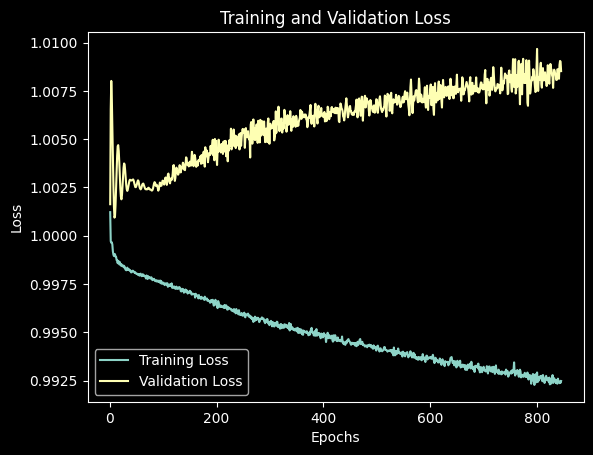

In [43]:
# Extract loss values from the history object
training_loss_MLP = history_MLP.history['loss']
validation_loss_MLP = history_MLP.history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(training_loss_MLP) + 1)

# Plot the training and validation loss values
plt.plot(epochs, training_loss_MLP, label='Training Loss')
plt.plot(epochs, validation_loss_MLP, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
# # Save the numpy array to a file
# if Main_bactest:
#     np.save('y_pred_MLP_backtest.npy', y_pred_MLP_backtest)
#     np.save('y_pred_MLP_all.npy', y_pred_MLP_all)

In [45]:
# if not Online:
#     y_pred_MLP_backtest = np.load("y_pred_MLP_backtest.npy")
#     y_pred_MLP_all = np.load("y_pred_MLP_all.npy")

##### GBDT(XGboost)

In [46]:
params = {
    "learning_rate": 0.01,
    "max_depth": 64,
    "max_leaves": 512,
    "min_child_weight": 512,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:squarederror",
}

dtrain = xgb.DMatrix(price_X_train, label=price_y_train)
dtest = xgb.DMatrix(price_X_test, label=price_y_test)
dbacktest = xgb.DMatrix(price_X_backtest)
dall = xgb.DMatrix(price_X_all)

evals = [(dtest, "eval"), (dtrain, "train")]
num_round = 200

# train_loss_GBDT = []
# val_loss_GBDT = []
# Define a callback function to monitor the training progress and capture loss data
# def callback(env):
#     iteration = env.iteration
#     train_rmse = env.evaluation_result_list[1][1]
#     val_rmse = env.evaluation_result_list[0][1]
#     train_loss_GBDT.append(train_rmse)
#     val_loss_GBDT.append(val_rmse)

bst = xgb.train(
    params, 
    dtrain, 
    num_round, 
    evals, 
    early_stopping_rounds=50, 
    verbose_eval=True
)

y_pred_GBDT_backtest = bst.predict(dbacktest)
y_pred_GBDT_all = bst.predict(dall)
mse_GBDT_train = mean_squared_error(price_y_train, bst.predict(dtrain))
mse_GBDT_test = mean_squared_error(price_y_test, bst.predict(dtest))

print(f"GBDT MSE(train): {mse_GBDT_train}")
print(f"GBDT MSE(test): {mse_GBDT_test}")
# GBDT MSE(train): 0.9476405621114625
# GBDT MSE(test): 1.002617615102808

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-rmse:1.11583	train-rmse:1.11573
[1]	eval-rmse:1.11368	train-rmse:1.11344
[2]	eval-rmse:1.11156	train-rmse:1.11121
[3]	eval-rmse:1.10948	train-rmse:1.10902
[4]	eval-rmse:1.10744	train-rmse:1.10684
[5]	eval-rmse:1.10544	train-rmse:1.10470
[6]	eval-rmse:1.10348	train-rmse:1.10260
[7]	eval-rmse:1.10155	train-rmse:1.10053
[8]	eval-rmse:1.09967	train-rmse:1.09851
[9]	eval-rmse:1.09781	train-rmse:1.09653
[10]	eval-rmse:1.09598	train-rmse:1.09460
[11]	eval-rmse:1.09420	train-rmse:1.09267
[12]	eval-rmse:1.09244	train-rmse:1.09080
[13]	eval-rmse:1.09071	train-rmse:1.08895
[14]	eval-rmse:1.08901	train-rmse:1.08712
[15]	eval-rmse:1.08736	train-rmse:1.08534
[16]	eval-rmse:1.08573	train-rmse:1.08360
[17]	eval-rmse:1.08414	train-rmse:1.08189
[18]	eval-rmse:1.08261	train-rmse:1.08019
[19]	eval-rmse:1.08106	train-rmse:1.07852
[20]	eval-rmse:1.07954	train-rmse:1.07688
[21]	eval-rmse:1.07804	train-rmse:1.07528
[22]	eval-rmse:1.07658	train-rmse:1.07371
[23]	eval-rmse:1.07517	train-rmse:1.07216
[2

In [47]:
eval_rmse = [1.11584, 1.11368, 1.11157, 1.10950, 1.10743, 1.10544, 1.10348, 1.10155, 1.09963, 1.09780, 
             1.09598, 1.09419, 1.09244, 1.09071, 1.08901, 1.08735, 1.08574, 1.08414, 1.08255, 1.08100, 
             1.07949, 1.07797, 1.07652, 1.07509, 1.07369, 1.07232, 1.07096, 1.06961, 1.06831, 1.06703,
             1.06579, 1.06456, 1.06335, 1.06217, 1.06102, 1.05987, 1.05877, 1.05768, 1.05661, 1.05555,
             1.05451, 1.05349, 1.05248, 1.05149, 1.05053, 1.04959, 1.04866, 1.04777, 1.04689, 1.04603,
             1.04520, 1.04437, 1.04357, 1.04277, 1.04199, 1.04123, 1.04049, 1.03974, 1.03901, 1.03828,
             1.03758, 1.03689, 1.03622, 1.03556, 1.03492, 1.03429, 1.03366, 1.03305, 1.03245, 1.03186, 
             1.03130, 1.03074, 1.03019, 1.02965, 1.02910, 1.02859, 1.02808, 1.02759, 1.02710, 1.02662, 
             1.02613, 1.02568, 1.02522, 1.02479, 1.02435, 1.02393, 1.02351, 1.02311, 1.02272, 1.02234, 
             1.02195, 1.02158, 1.02120, 1.02084, 1.02050, 1.02016, 1.01983, 1.01950, 1.01917, 1.01884, 
             1.01852, 1.01820, 1.01791, 1.01763, 1.01733, 1.01705, 1.01679, 1.01652, 1.01626, 1.01601, 
             1.01576, 1.01551, 1.01526, 1.01502, 1.01478, 1.01456, 1.01434, 1.01409, 1.01389, 1.01369, 
             1.01349, 1.01330, 1.01311, 1.01292, 1.01274, 1.01256, 1.01238, 1.01219, 1.01202, 1.01184, 
             1.01168, 1.01152, 1.01134, 1.01121, 1.01106, 1.01093, 1.01079, 1.01066, 1.01052, 1.01037, 
             1.01023, 1.01011, 1.00998, 1.00986, 1.00974, 1.00961, 1.00949, 1.00938, 1.00927, 1.00916, 
             1.00906, 1.00896, 1.00885, 1.00875, 1.00865, 1.00854, 1.00845, 1.00836, 1.00826, 1.00816, 
             1.00808, 1.00798, 1.00788, 1.00780, 1.00773, 1.00767, 1.00760, 1.00752, 1.00746, 1.00739, 
             1.00732, 1.00725, 1.00717, 1.00711, 1.00704, 1.00698, 1.00691, 1.00684, 1.00679, 1.00674, 
             1.00669, 1.00664, 1.00660, 1.00655, 1.00651, 1.00645, 1.00639, 1.00634, 1.00629, 1.00624, 
             1.00619, 1.00616, 1.00612, 1.00608, 1.00604, 1.00601, 1.00598, 1.00594, 1.00589, 1.00585]
train_rmse = [1.11572, 1.11344, 1.11122, 1.10900, 1.10683, 1.10472, 1.10263, 1.10057, 1.09855, 1.09656, 
              1.09460, 1.09268, 1.09078, 1.08894, 1.08713, 1.08534, 1.08360, 1.08187, 1.08017, 1.07851, 
              1.07687, 1.07526, 1.07369, 1.07215, 1.07063, 1.06913, 1.06767, 1.06623, 1.06480, 1.06340,
              1.06203, 1.06069, 1.05937, 1.05808, 1.05681, 1.05554, 1.05432, 1.05312, 1.05194, 1.05079,
              1.04965, 1.04854, 1.04742, 1.04635, 1.04530, 1.04425, 1.04323, 1.04223, 1.04124, 1.04026,
              1.03931, 1.03837, 1.03746, 1.03655, 1.03567, 1.03481, 1.03395, 1.03311, 1.03229, 1.03148,
              1.03070, 1.02991, 1.02915, 1.02840, 1.02766, 1.02693, 1.02622, 1.02553, 1.02484, 1.02417, 
              1.02351, 1.02286, 1.02222, 1.02159, 1.02098, 1.02038, 1.01979, 1.01920, 1.01863, 1.01807, 
              1.01751, 1.01696, 1.01643, 1.01590, 1.01539, 1.01487, 1.01437, 1.01388, 1.01340, 1.01293, 
              1.01247, 1.01200, 1.01155, 1.01111, 1.01067, 1.01025, 1.00983, 1.00942, 1.00903, 1.00863, 
              1.00824, 1.00786, 1.00748, 1.00712, 1.00675, 1.00639, 1.00604, 1.00570, 1.00536, 1.00502, 
              1.00470, 1.00438, 1.00407, 1.00376, 1.00345, 1.00314, 1.00285, 1.00257, 1.00228, 1.00200, 
              1.00172, 1.00145, 1.00119, 1.00092, 1.00066, 1.00040, 1.00015, 0.99991, 0.99966, 0.99943, 
              0.99919, 0.99896, 0.99873, 0.99850, 0.99828, 0.99807, 0.99785, 0.99765, 0.99745, 0.99724, 
              0.99705, 0.99686, 0.99666, 0.99647, 0.99629, 0.99610, 0.99592, 0.99574, 0.99557, 0.99540, 
              0.99522, 0.99506, 0.99489, 0.99473, 0.99456, 0.99442, 0.99426, 0.99411, 0.99396, 0.99381, 
              0.99366, 0.99352, 0.99339, 0.99326, 0.99312, 0.99298, 0.99285, 0.99271, 0.99259, 0.99246, 
              0.99233, 0.99220, 0.99208, 0.99195, 0.99183, 0.99171, 0.99159, 0.99147, 0.99137, 0.99125, 
              0.99114, 0.99103, 0.99093, 0.99081, 0.99071, 0.99061, 0.99053, 0.99044, 0.99034, 0.99026, 
              0.99016, 0.99006, 0.98997, 0.98989, 0.98981, 0.98972, 0.98962, 0.98953, 0.98945, 0.98937]

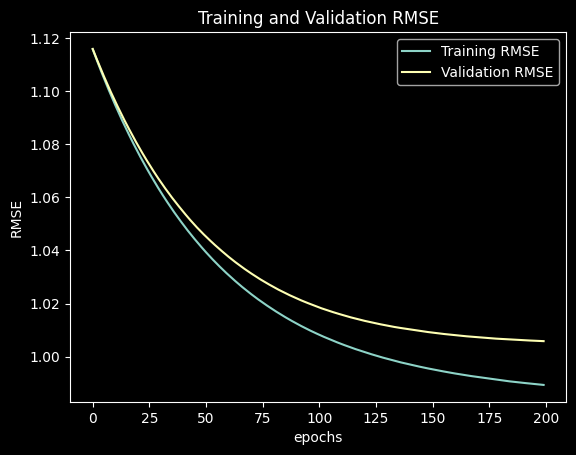

In [48]:
plt.plot(train_rmse, label='Training RMSE')
plt.plot(eval_rmse, label='Validation RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

In [49]:
# if Main_bactest:
#     # Save the numpy array to a file
#     np.save("y_pred_GBDT_backtest.npy", y_pred_GBDT_backtest)
#     np.save("y_pred_GBDT_all.npy", y_pred_GBDT_all)

In [50]:
# if not Online:
#     y_pred_GBDT_backtest = np.load('y_pred_GBDT_backtest.npy')
#     y_pred_GBDT_all = np.load('y_pred_GBDT_all.npy')

In [51]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 2101.703125 MB


##### AGRU

##### Sequence preprocessing

In [52]:
from tqdm import tqdm  # For status process bar

# Create sequences of variable length for each stock
def create_sequences(df, sequence_length, begin_index, end_index):
    """
    sequence length: number of time steps in the entire sequence.
    In this paper, sequence length = 30.

    type: 'train' or 'test'

    begin index: index of the first sequence
    end index: index of the last sequence
    """
    sequences = []
    labels = []
    for stock in tqdm(df["ts_code"].unique(), desc="Stocks Progress", ncols=100):
        # Single stock dataframe
        stock_df = df[df["ts_code"] == stock].reset_index(drop=True)
        for i in range(sequence_length + begin_index, end_index + 2):
            # The last sequence is included.
            seq = stock_df.iloc[i - sequence_length : i][
                [
                    "OPEN_processed",
                    "HIGH_processed",
                    "LOW_processed",
                    "CLOSE_processed",
                    "VWAP_processed",
                    "VOLUME_processed",
                ]
            ].values
            label = stock_df.iloc[i - 1]["Label_processed"]
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)


# Set the desired sequence length
sequence_length = 30

train_X, train_y = create_sequences(price, sequence_length, 0, len(date_train) - 1)
# Note: len(date_train) + len(date_test) is the length of Modeling date.
test_X, test_y = create_sequences(
    price,
    sequence_length,
    len(date_train) - sequence_length + 1,
    len(date_train) + len(date_test) - 1,
)
drop_X, drop_y = create_sequences(
    price,
    sequence_length,
    len(date_train) + len(date_test) - sequence_length + 1,
    len(date_all) - 1,
)

Stocks Progress: 100%|████████████████████████████████████████████| 239/239 [00:09<00:00, 24.27it/s]


In [53]:
print(train_X.shape)
print(test_X.shape)
print(drop_X.shape)

(286561, 30, 6)
(70744, 30, 6)
(2629, 30, 6)


In [54]:
# if Main_bactest:
#     # # Save the numpy array to a file
#     np.save("train_X.npy", train_X)
#     np.save("train_y.npy", train_y)
#     np.save("test_X.npy", test_X)
#     np.save("test_y.npy", test_y)

In [55]:
# if not Online:
#     train_X = np.load('train_X.npy')
#     train_y = np.load('train_y.npy')
#     test_X = np.load('test_X.npy')
#     test_y = np.load('test_y.npy')

In [56]:
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 2893.921875 MB


In [57]:
# Define the AGRU model
inputs = Input(shape=(30, 6))
gru = GRU(units=6, return_sequences=True)(inputs)
att = Attention()([gru, gru])
gru = GRU(units=6)(att)
outputs = Dense(1)(gru)

model_AGRU = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_AGRU.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error")

# Define early stopping criteria
early_stopping_AGRU = EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)

# Train the model
history_AGRU = model_AGRU.fit(
    train_X,
    train_y,
    epochs=200,
    batch_size=len(stocks_code),
    validation_data=(test_X, test_y),
    callbacks=[early_stopping_AGRU],
)

# Evaluate the model
loss = model_AGRU.evaluate(test_X, test_y)
print("Model trained with loss:", loss)

Epoch 1/200


2024-05-02 22:03:05.023660: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1199/1199 [==============================] - ETA: 0s - loss: 0.9991

2024-05-02 22:03:37.859155: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1199/1199 [==============================] - 39s 29ms/step - loss: 0.9991 - val_loss: 1.0063
Epoch 2/200
1199/1199 [==============================] - 34s 28ms/step - loss: 0.9990 - val_loss: 1.0043
Epoch 3/200
1199/1199 [==============================] - 34s 28ms/step - loss: 0.9989 - val_loss: 1.0093
Epoch 4/200
1199/1199 [==============================] - 33s 28ms/step - loss: 0.9989 - val_loss: 1.0082
Epoch 5/200
1199/1199 [==============================] - 32s 27ms/step - loss: 0.9988 - val_loss: 1.0041
Epoch 6/200
1199/1199 [==============================] - 32s 27ms/step - loss: 0.9987 - val_loss: 1.0055
Epoch 7/200
1199/1199 [==============================] - 34s 28ms/step - loss: 0.9987 - val_loss: 1.0075
Epoch 8/200
1199/1199 [==============================] - 34s 28ms/step - loss: 0.9986 - val_loss: 1.0055
Epoch 9/200
1199/1199 [==============================] - 33s 28ms/step - loss: 0.9986 - val_loss: 1.0074
Epoch 10/200
1199/1199 [==============================] - 33s 28ms/

2024-05-02 23:47:56.263709: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2211/2211 [==============================] - 14s 6ms/step - loss: 1.0096
Model trained with loss: 1.0095902681350708


In [58]:
# Evaluate the model on test data
y_pred_AGRU_train = model_AGRU.predict(train_X)
y_pred_AGRU_test = model_AGRU.predict(test_X)
y_pred_AGRU_drop = model_AGRU.predict(drop_X)
y_pred_AGRU_backtest = np.concatenate(
    (y_pred_AGRU_test.reshape(-1), y_pred_AGRU_drop.reshape(-1))
)
y_pred_AGRU_all = np.concatenate(
    (y_pred_AGRU_train.reshape(-1), y_pred_AGRU_backtest.reshape(-1))
)
mse_AGRU_train = mean_squared_error(train_y, y_pred_AGRU_train)
mse_AGRU_test = mean_squared_error(test_y, y_pred_AGRU_test)
print(f"AGRU MSE(train): {mse_AGRU_train}")
print(f"AGRU MSE(test): {mse_AGRU_test}")
# AGRU MSE(train): 0.9896615693578518
# AGRU MSE(test): 0.9960141348406323

   1/8956 [..............................] - ETA: 1:21:39

2024-05-02 23:48:10.866296: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


83/83 [==============================] - 0s 6ms/step
AGRU MSE(train): 0.9883233933320997
AGRU MSE(test): 1.0095901529368327


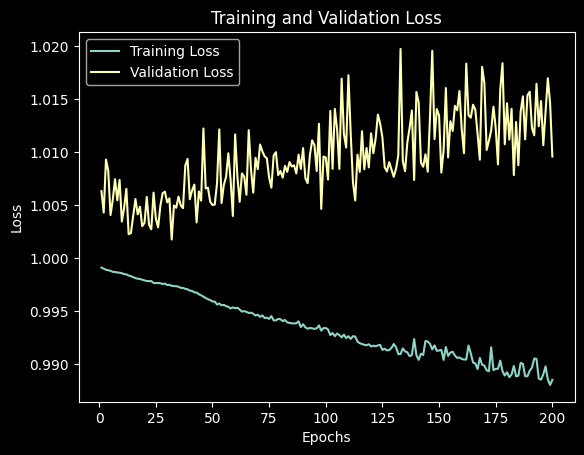

In [59]:
# Extract loss values from the history object
training_loss_AGRU = history_AGRU.history['loss']
validation_loss_AGRU = history_AGRU.history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(training_loss_AGRU) + 1)

# Plot the training and validation loss values
plt.plot(epochs, training_loss_AGRU, label='Training Loss')
plt.plot(epochs, validation_loss_AGRU, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
# if Main_bactest:
#     # Save the numpy array to a file
#     np.save("y_pred_AGRU_all.npy", y_pred_AGRU_all)
#     np.save("y_pred_AGRU_backtest.npy", y_pred_AGRU_backtest)

In [61]:
# if not Online:
#     y_pred_AGRU_backtest = np.load('y_pred_AGRU_backtest.npy')
#     y_pred_AGRU_all = np.load('y_pred_AGRU_all.npy')

##### Ensemble

In [62]:
def Create_Factor_all(y_pred_all):
    # This is for y_pred_all.
    factor_df = price[["trade_date", "ts_code"]]  # Date and stock
    factor_df.loc[:, "Factor_values"] = y_pred_all  # Add factor values
    factor_df = factor_df.pivot(
        index="trade_date", columns="ts_code", values="Factor_values"
    )  # Transfer to factor dataframe
    return factor_df

def Create_Factor_backtest(y_pred_backtest):
    # This is for y_pred_all.
    factor_df = price.loc[price["trade_date"].isin(date_backtest), :][
        ["trade_date", "ts_code"]
    ]  # Date and stock
    factor_df.loc[:, "Factor_values"] = y_pred_backtest  # Add factor values
    factor_df = factor_df.pivot(
        index="trade_date", columns="ts_code", values="Factor_values"
    )  # Transfer to factor dataframe
    return factor_df

def Create_ICIR_df(factor_DF):
    # This is for y_pred_all.
    IC_series = factor_DF.corrwith(price_return, axis=1, method="spearman")
    ICIR_df = IC_series.shift(1).rolling(60).apply(lambda x: x.mean() / x.std())
    ICIR_df = ICIR_df[
        ICIR_df.index.isin(date_backtest)
    ]  # Select the ICIR in the test date.
    return ICIR_df

In [63]:
# price.loc[price["trade_date"].isin(date_GRU), :]

In [64]:
MLP_factor_all = Create_Factor_all(y_pred_MLP_all)
MLP_factor_backtest = Create_Factor_backtest(y_pred_MLP_backtest)
GBDT_factor_all = Create_Factor_all(y_pred_GBDT_all)
GBDT_factor_backtest = Create_Factor_backtest(y_pred_GBDT_backtest)

AGRU_factor_all = price.loc[price["trade_date"].isin(date_GRU), :].reset_index(
    drop=True
)
AGRU_factor_all = AGRU_factor_all[["trade_date", "ts_code"]]  # Date and stock
AGRU_factor_all.loc[:, "AGRU"] = y_pred_AGRU_all  # Add factor values
AGRU_factor_all = AGRU_factor_all.pivot(
    index="trade_date", columns="ts_code", values="AGRU"
)  # Transfer to factor dataframe
AGRU_factor_backtest = Create_Factor_backtest(y_pred_AGRU_backtest)

# Use abs()
MLP_ICIR = Create_ICIR_df(MLP_factor_all)
MLP_ICIR = MLP_ICIR.abs()

GBDT_ICIR = Create_ICIR_df(GBDT_factor_all)
GBDT_ICIR = GBDT_ICIR.abs()

AGRU_ICIR = Create_ICIR_df(AGRU_factor_all)
AGRU_ICIR = AGRU_ICIR.abs()

When you use the `exec()` function inside a function to dynamically create variables, the variables created using `exec()` will be local to the function by default. This means that they will only exist within the scope of that function and cannot be accessed outside of it.

Here's an example to illustrate this behavior:

```python
def create_variable():
    exec("new_var = 10")
    print("Inside function - new_var:", new_var)

create_variable()

# Trying to access new_var outside the function will result in a NameError
# print("Outside function - new_var:", new_var)
```

In this example:
- The `exec("new_var = 10")` statement creates a variable `new_var` with a value of 10 inside the `create_variable()` function.
- When we try to access `new_var` within the function, it works fine and prints the value.
- However, if you try to access `new_var` outside the function, it will result in a `NameError` because `new_var` is local to the `create_variable()` function and does not exist in the global scope.

If you want to make the dynamically created variables global, you can achieve this by specifying the `globals()` dictionary as the `globals` argument in the `exec()` function. This way, the variables will be created in the global scope.

Here's an example:

```python
def create_global_variable():
    exec("global global_var; global_var = 20", globals())
    print("Inside function - global_var:", global_var)

create_global_variable()

# Accessing global_var outside the function works as it is now a global variable
print("Outside function - global_var:", global_var)
```

In this modified example, `global_var` is created as a global variable using `exec()` with the `globals()` dictionary as an argument. This allows `global_var` to be accessed outside the function as well.

In [65]:
# Ensembling
def Ensemble_ICIR_weight():
    # Ensemble the models based on ICIR weight
    SUM_ICIR = MLP_ICIR + GBDT_ICIR + AGRU_ICIR
    MLP_ratio = MLP_ICIR / SUM_ICIR
    GBDT_ratio = GBDT_ICIR / SUM_ICIR
    AGRU_ratio = AGRU_ICIR / SUM_ICIR

    MLP_weight = MLP_factor_backtest.multiply(MLP_ratio, axis=0)
    GBDT_weight = GBDT_factor_backtest.multiply(GBDT_ratio, axis=0)
    AGRU_weight = AGRU_factor_backtest.multiply(AGRU_ratio, axis=0)

    ICIR_weight = MLP_weight + GBDT_weight + AGRU_weight
    return ICIR_weight
def Ensemble_ICIR_max(*ICIR_df, type_list):
    # Ensemble the models based on max ICIR

    # Concatenate ICIR DataFrames into Combine_df
    # for ICIR in ICIR_df:
    #     Combine_df = pd.concat([Combine_df, ICIR], axis=1)
    Combine_df = pd.concat(ICIR_df, axis=1)
    Combine_df.columns = type_list
    # print(Combine_df)
    Combine_ranks = Combine_df.rank(axis=1, ascending=False)

    # Choose max ICIR and assign it as 1, others as 0
    Keep_df = Combine_ranks.applymap(lambda x: 1 if x == 1 else 0)

    Ensemble_max = pd.DataFrame()
    for TYPE in type_list:
        # Dynamically create variable names using exec()
        keepp = Keep_df[TYPE]
        # Find factor df use globals()
        positionn = globals()[f"{TYPE}_factor_backtest"].where(keepp == 1, 0)
        Ensemble_max = Ensemble_max.add(positionn, fill_value=0)
    return Ensemble_max

In [66]:
Ensemble_max_factor_df = Ensemble_ICIR_max(MLP_ICIR, GBDT_ICIR, AGRU_ICIR,
                                           type_list=["MLP", "GBDT", "AGRU"])

In [67]:
Ensemble_weight_factor_df = Ensemble_ICIR_weight()

In [68]:
# if Main_bactest:
#     MLP_factor_backtest.to_csv("MLP_factor_backtest.csv")
#     GBDT_factor_backtest.to_csv("GBDT_factor_backtest.csv")
#     AGRU_factor_backtest.to_csv("AGRU_factor_backtest.csv")
#     # Ensemble_factor_df.to_csv("Ensemble_factor_df.csv")

In [69]:
Ensemble_weight_factor_df

ts_code,000001.SZ,000002.SZ,000063.SZ,000069.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,...,603288.SH,603369.SH,603501.SH,603659.SH,603799.SH,603806.SH,603833.SH,603899.SH,603986.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2023-01-20,-0.038427,-0.034509,0.036907,-0.014575,-0.015502,0.018625,-0.042182,0.001253,0.018043,0.030187,...,-0.018236,0.048358,0.003273,0.069829,0.059002,-0.025438,-0.040542,0.067267,0.003352,-0.054002
2023-01-30,0.051285,0.068933,0.021143,-0.016873,-0.096510,0.023174,-0.068120,-0.070935,0.072240,-0.029573,...,0.010245,0.032082,-0.016122,0.085373,0.103556,0.017319,-0.032279,0.139776,0.030166,-0.028829
2023-01-31,0.048658,0.052552,0.000822,-0.019006,-0.026691,0.026556,-0.018013,0.070922,-0.008086,0.016395,...,-0.006879,0.033417,-0.010405,0.050407,0.034007,-0.012601,-0.021176,0.046075,-0.017966,-0.042840
2023-02-01,0.087764,-0.022160,0.034379,0.007600,-0.024831,0.024916,-0.058051,0.016407,0.045024,0.016439,...,-0.034455,0.050995,-0.041119,0.039749,-0.015994,-0.041347,-0.053262,0.051371,-0.044303,-0.011135
2023-02-02,0.017174,0.051260,0.048197,-0.010355,-0.013720,0.027686,-0.012117,-0.013791,0.115691,-0.018296,...,-0.046532,0.065346,-0.032763,0.038196,-0.001881,-0.040259,-0.083938,0.238976,-0.008507,-0.037681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,0.003644,-0.016097,0.069500,-0.001494,0.078377,0.014950,0.012904,0.029855,-0.001923,0.011608,...,0.143146,0.348236,0.253048,0.127210,0.012256,0.135694,0.337785,0.216751,0.036112,-0.062432
2024-04-25,-0.028231,-0.032671,0.039212,-0.037581,0.063538,-0.021135,0.022610,0.013407,0.112604,0.062111,...,0.096236,0.284955,0.182906,0.148512,0.020430,0.119350,0.107071,0.179871,0.106412,-0.086056
2024-04-26,0.051592,0.047937,0.043063,-0.063491,0.088110,-0.018211,0.081414,0.114664,0.127104,0.042225,...,0.046194,0.206849,0.109856,0.122642,0.067850,0.136843,0.148940,0.139759,0.129934,-0.004654


In [70]:
# if Main_bactest:
#     Ensemble_weight_factor_df.to_csv("Ensemble_weight_factor_df.csv")

### Back testing

In [71]:
# Split return rates data
price_return_backtest = price_return.loc[price_return.index.isin(date_backtest), :]
benchmark_return_backtest = benchmark_return.loc[
    benchmark_return.index.isin(date_backtest), :
]
HS_300_backtest = HS_300.loc[HS_300.index.isin(date_backtest), :]["000300.SH"]
CS_500_backtest = CS_500.loc[HS_300.index.isin(date_backtest), :]["000905.SH"]
CS_1000_backtest = CS_1000.loc[HS_300.index.isin(date_backtest), :]["000852.SH"]

price_backtest = price.loc[price["trade_date"].isin(date_backtest), :]
price_X_backtest = price_backtest[X_indexes].values
price_y_backtest = price_backtest[y_index].values

In [72]:
# if Main_bactest:
#     price_return_backtest.to_csv("price_return_backtest.csv")
#     benchmark_return_backtest.to_csv("benchmark_return_backtest.csv")
#     HS_300_backtest.to_csv("HS_300_backtest.csv")
#     CS_1000_backtest.to_csv("CS_1000_backtest.csv")
#     CS_500_backtest.to_csv("CS_500_backtest.csv")

In [73]:
# if not Online:
#     # price_backtest = pd.read_csv(path + 'price_backtest.csv',
#     #                          parse_dates=["trade_date"])
#     price_return_backtest = pd.read_csv(path + 'price_return_backtest.csv',
#                                     parse_dates=['trade_date'],
#                                     index_col="trade_date")

#     HS_300_backtest = pd.read_csv(path + 'HS_300_backtest.csv',
#                               parse_dates=["trade_date"],
#                               index_col="trade_date")
#     HS_300_backtest = HS_300_backtest['000300.SH']

#     CS_500_backtest = pd.read_csv(path + 'CS_500_backtest.csv',
#                               parse_dates=["trade_date"],
#                               index_col="trade_date")
#     CS_500_backtest = CS_500_backtest['000905.SH']

#     CS_1000_backtest = pd.read_csv(path + 'CS_1000_backtest.csv',
#                                parse_dates=["trade_date"],
#                                index_col="trade_date")
#     CS_1000_backtest = CS_1000_backtest['000852.SH']

In [74]:
def Ensure_position(DF):
    # We add a column named 'Monday' and change positions every Monday.
    DF = DF.shift(1)  # Move one step forward to ensure position
    DF["Monday"] = (DF.index.dayofweek == 0).astype(int)  # Shift except Monday

    # Get the columns to shift (all columns except 'Monday')
    cols_to_shift = DF.columns[DF.columns != "Monday"]

    DF.loc[DF["Monday"] == 0, cols_to_shift] = np.nan
    DF.fillna(
        method="ffill", inplace=True
    )  # Forward fill, holing positions for a week.
    DF.fillna(value=0, inplace=True)  # Fill remaining NaN with 0
    return DF

def Layer_Backtest(factor_df, type):
    # layer number
    num_layers = 20

    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)
    layer_allocation

    # import matplotlib.cm as cm

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")

    # Define a color map to use for changing colors progressively
    # colors = plt.cm.jet(np.linspace(0, 1, num_layers))

    global profit_long, profit_short
    profit_long = profit_short = None

    def Long_Short(Num_layers, Layer, Profit):
        global profit_long, profit_short
        long_layer = Num_layers - 1
        short_layer = 0
        if Layer == short_layer:
            profit_short = Profit
            # The short profit comes from the decline of the stock.
            profit_short = profit_short.apply(
                lambda x: x + 1 if x == 0 else -x + (1 - 0.0003)
            )
            profit_short = profit_short.cumprod()
            profit_short *= 0.5
        elif Layer == long_layer:
            profit_long = Profit
            profit_long = profit_long.apply(
                lambda x: x + 1 if x == 0 else x + (1 - 0.0003)
            )
            profit_long = profit_long.cumprod()
            profit_long *= 0.5

    Long_position_df = None
    for layer in range(0, num_layers):
        # Ensure holding stocks
        hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(
            layer_allocation == layer, 1
        )
        hold_flag_matrix = Ensure_position(hold_flag_matrix)
        if layer == num_layers - 1:
            Long_position_df = hold_flag_matrix.copy()

        # Delete 'Monday' to fit into yield dataframe.
        del hold_flag_matrix["Monday"]

        # Calculate the sum of each line in turn.
        stock_amount_sum = hold_flag_matrix.sum(axis=1)

        # Calculate the weight of each stock. (Average distribution at the same level)
        weight_allocation = hold_flag_matrix.apply(
            lambda x: x / stock_amount_sum, axis=0
        ).fillna(0)

        # Calculate the daily profit rate. And prepare to calculate cumprod.
        profit = (weight_allocation * price_return_backtest).sum(axis=1)

        # Create Long and Short position
        Long_Short(num_layers, layer, profit)

        # Calculate the daily equity and draw.
        # Using the 'viridis' colormap with a gradient based on layer number
        colors = cm.viridis(layer / num_layers)
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label=layer, legend=True, color=colors)

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    (profit_long + profit_short).plot(color="orange", label="long_short", legend=True)
    plt.title(f"20-Layered Portfolio Equity ({type})")
    plt.legend(title="Layer", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

    return profit_long, Long_position_df

In [75]:
def Layer_Backtest(factor_df, type):
    # layer number
    num_layers = 20

    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)
    layer_allocation

    # import matplotlib.cm as cm

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")

    # Define a color map to use for changing colors progressively
    # colors = plt.cm.jet(np.linspace(0, 1, num_layers))

    global profit_long, profit_short
    profit_long = profit_short = None

    def Long_Short(Num_layers, Layer, Profit):
        global profit_long, profit_short
        long_layer = Num_layers - 1
        short_layer = 0
        if Layer == short_layer:
            profit_short = Profit
            # The short profit comes from the decline of the stock.
            profit_short = profit_short.apply(
                lambda x: x + 1 if x == 0 else -x + (1 - 0.0003)
            )
            profit_short = profit_short.cumprod()
            profit_short *= 0.5
        elif Layer == long_layer:
            profit_long = Profit
            profit_long = profit_long.apply(
                lambda x: x + 1 if x == 0 else x + (1 - 0.0003)
            )
            profit_long = profit_long.cumprod()
            profit_long *= 0.5

    Long_position_df = None
    for layer in range(0, num_layers):
        # Ensure holding stocks
        hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(
            layer_allocation == layer, 1
        )
        hold_flag_matrix = Ensure_position(hold_flag_matrix)
        if layer == num_layers - 1:
            Long_position_df = hold_flag_matrix.copy()

        # Delete 'Monday' to fit into yield dataframe.
        del hold_flag_matrix["Monday"]

        # Calculate the sum of each line in turn.
        stock_amount_sum = hold_flag_matrix.sum(axis=1)

        # Calculate the weight of each stock. (Average distribution at the same level)
        weight_allocation = hold_flag_matrix.apply(
            lambda x: x / stock_amount_sum, axis=0
        ).fillna(0)

        # Calculate the daily profit rate. And prepare to calculate cumprod.
        profit = (weight_allocation * price_return_backtest).sum(axis=1)

        # Create Long and Short position
        Long_Short(num_layers, layer, profit)

        # Calculate the daily equity and draw.
        # Using the 'viridis' colormap with a gradient based on layer number
        colors = cm.viridis(layer / num_layers)
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label=layer, legend=True, color=colors)

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    (profit_long + profit_short).plot(color="orange", label="long_short", legend=True)
    plt.title(f"20-Layered Portfolio Equity ({type})")
    plt.legend(title="Layer", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

    return profit_long, Long_position_df

### Ensemble Backtest

In [76]:
# Ensemble_factor_df_a = Ensemble_factor_df[Ensemble_factor_df.index >= "2023-07-01"]

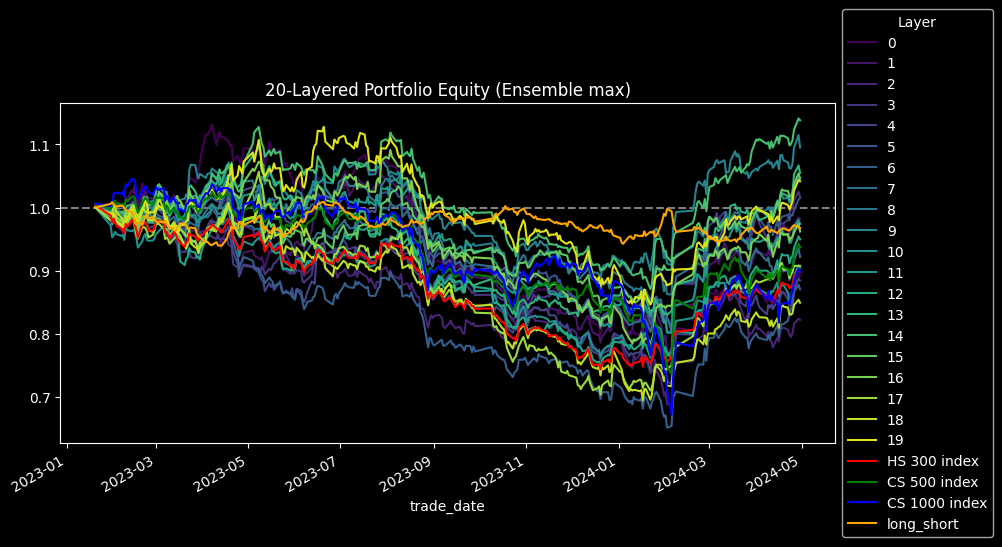

In [77]:
profit_long_Ensemble_max, \
Long_position_df_Ensemble_max = Layer_Backtest(Ensemble_max_factor_df, "Ensemble max")

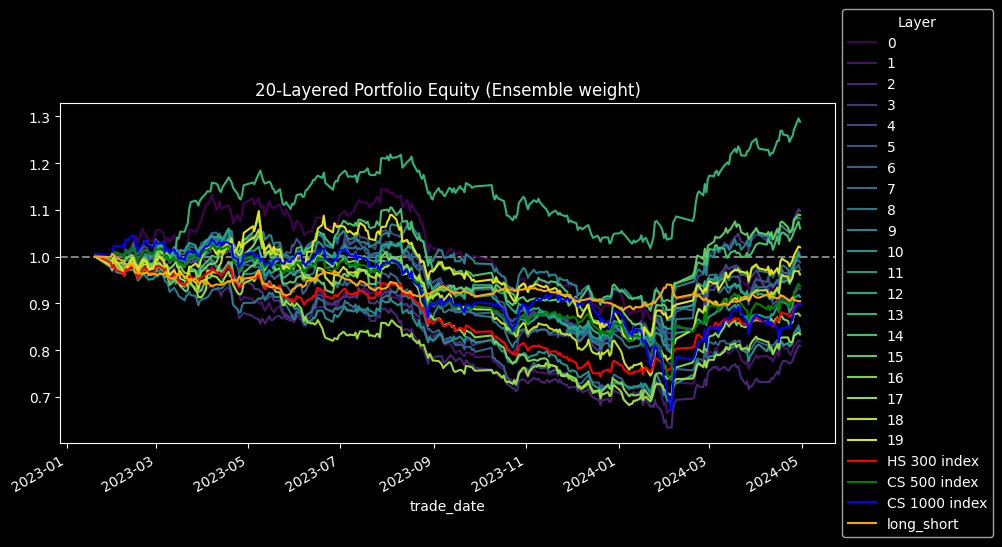

In [78]:
profit_long_Ensemble_weight, \
Long_position_df_Ensemble_weight = Layer_Backtest(Ensemble_weight_factor_df, "Ensemble weight")

In [79]:
Long_position_df_Ensemble_weight.to_csv("Long_position_df_Ensemble_weight.csv")

### MLP Backtest

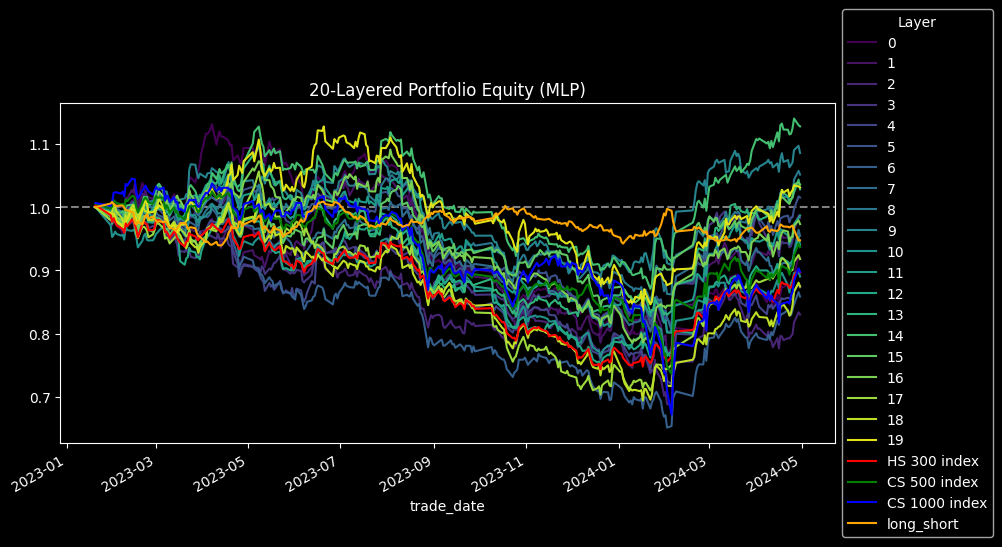

In [80]:
profit_long_MLP, Long_position_df_MLP = Layer_Backtest(MLP_factor_backtest, "MLP")

### GBDT Backtest

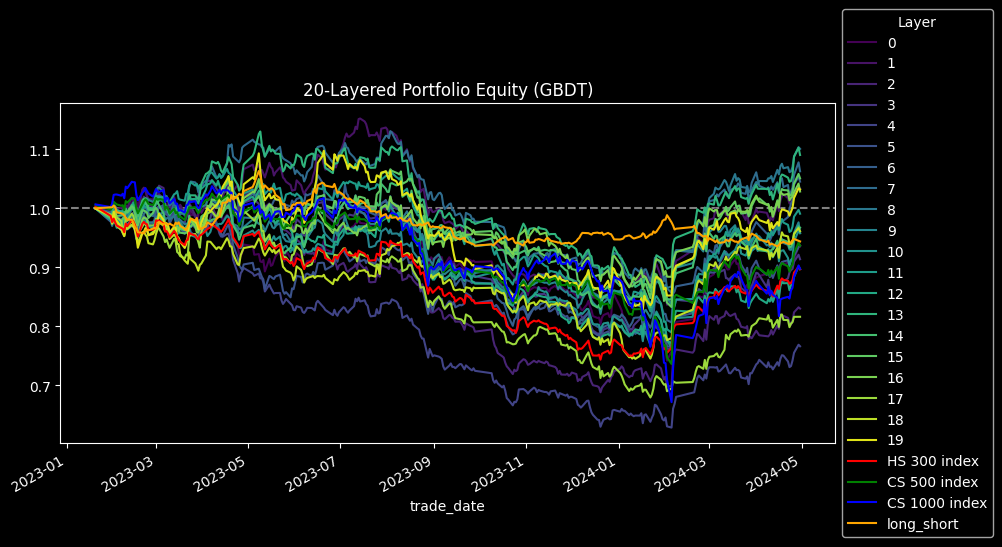

In [81]:
profit_long_GBDT, Long_position_df_GBDT = Layer_Backtest(GBDT_factor_backtest, "GBDT")

### AGRU Backtest

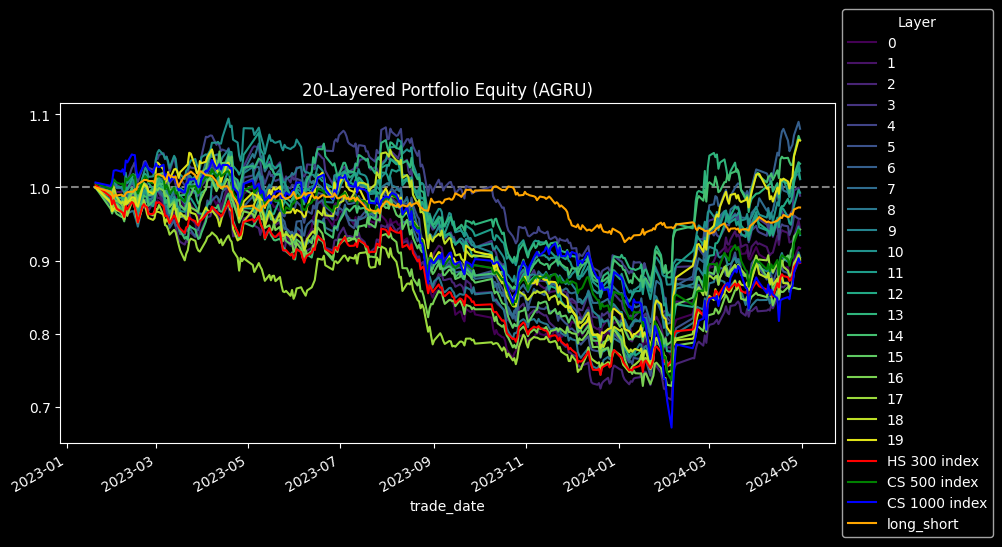

In [82]:
profit_long_AGRU, Long_position_df_AGRU = Layer_Backtest(AGRU_factor_backtest, "AGRU")

### Ensure future position

In [83]:
def Ensure_Future_position_all(factor_df, layer):
    # layer number
    num_layers = 20

    last_day = factor_df.iloc[-1, :]
    # Calculte the ranks of factors daily.
    factor_ranks = last_day.rank(ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(last_day) / num_layers)).fillna(0)

    selected_stocks = list(layer_allocation[layer_allocation == layer].index)
    return selected_stocks

selected_stocks_main = Ensure_Future_position_all(Ensemble_weight_factor_df, 19)
# In this condition, the long position is in layer 19.
selected_stocks_main

['000063.SZ',
 '000069.SZ',
 '000157.SZ',
 '000333.SZ',
 '000977.SZ',
 '300015.SZ',
 '601111.SH',
 '601117.SH',
 '601166.SH',
 '601881.SH',
 '601998.SH']

In [84]:
all_stocks[all_stocks['ts_code'].isin(selected_stocks_main)]

,ts_code,symbol,name,area,industry,fullname,enname,cnspell,market,exchange,curr_type,list_status,list_date,delist_date,is_hs,act_name,act_ent_type
53,000063.SZ,000063,中兴通讯,深圳,通信设备,中兴通讯股份有限公司,Zte Corporation,zxtx,主板,SZSE,CNY,L,19971118,None,S,无实际控制人,无
57,000069.SZ,000069,华侨城A,深圳,全国地产,深圳华侨城股份有限公司,"Shenzhen Overseas Chinese Town Co., Ltd",hqca,主板,SZSE,CNY,L,19970910,None,S,国务院国有资产监督管理委员会,中央国企
71,000157.SZ,000157,中联重科,湖南,工程机械,中联重科股份有限公司,Zoomlion Heavy Industry Science and Technology...,zlzk,主板,SZSE,CNY,L,20001012,None,S,None,None
76,000333.SZ,000333,美的集团,广东,家用电器,美的集团股份有限公司,"Midea Group Co., Ltd",mdjt,主板,SZSE,CNY,L,20130918,None,S,None,None
486,000977.SZ,000977,浪潮信息,山东,IT设备,浪潮电子信息产业股份有限公司,"Ieit Systems Co., Ltd.",lcxx,主板,SZSE,CNY,L,20000608,None,S,None,None
1627,300015.SZ,300015,爱尔眼科,湖南,医疗保健,爱尔眼科医院集团股份有限公司,"Aier Eye Hospital Group Co.,Ltd",aeyk,创业板,SZSE,CNY,L,20091030,None,S,None,None
3913,601111.SH,601111,中国国航,北京,空运,中国国际航空股份有限公司,Air China Limited,zggh,主板,SSE,CNY,L,20060818,None,H,None,None
3916,601117.SH,601117,中国化学,北京,建筑工程,中国化学工程股份有限公司,"China National Chemical Engineering Co., Ltd",zghx,主板,SSE,CNY,L,20100107,None,H,None,None
3932,601166.SH,601166,兴业银行,福建,银行,兴业银行股份有限公司,"Industrial Bank Co.,Ltd.",xyyh,主板,SSE,CNY,L,20070205,None,H,None,None
4061,601881.SH,601881,中国银河,北京,证券,中国银河证券股份有限公司,"China Galaxy Securities Co.,Ltd.",zgyh,主板,SSE,CNY,L,20170123,None,H,None,None


### Simple Backtest
(Small number of stocks)

In [85]:
def Simple_Backtest(factor_df, stock_num, Ascending):
    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=Ascending)

    # Create position_df based on top 3 ranks
    position_df = factor_ranks.apply(lambda x: x <= stock_num).astype(int)
    position_df = Ensure_position(position_df)

    # Delete 'Monday' to fit into yield dataframe.
    del position_df["Monday"]

    # Calculate the sum of each line in turn.
    stock_amount_sum = position_df.sum(axis=1)

    # Calculate the weight of each stock. (Average distribution at the same level)
    weight_allocation = position_df.apply(
        lambda x: x / stock_amount_sum, axis=0
    ).fillna(0)

    # Calculate the daily profit rate. And prepare to calculate cumprod.
    profit = (weight_allocation * price_return_backtest).sum(axis=1)

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")
    # Calculate the daily equity and draw.
    profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit.cumprod().plot(label="Stocks", legend=True, color="#800080")

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    plt.title(f"Equity of {stock_num} stocks")
    plt.legend(title="Index", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

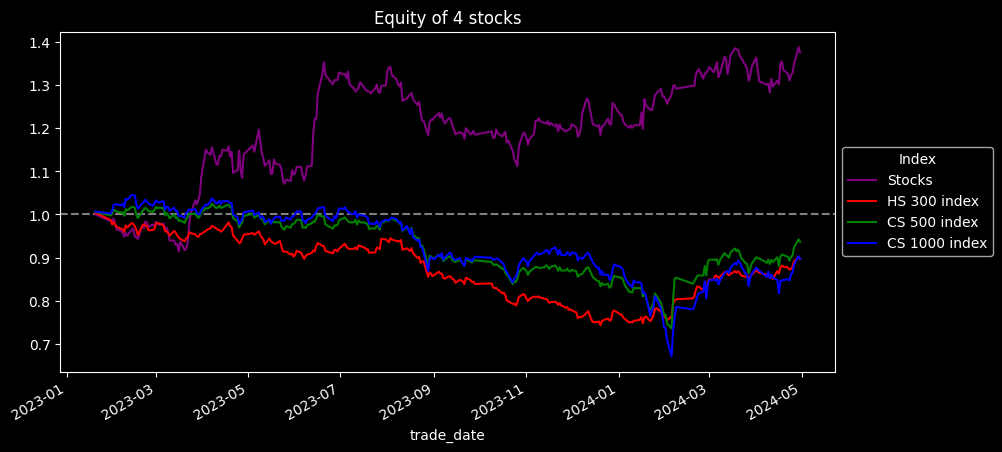

In [86]:
Simple_Backtest(Ensemble_weight_factor_df, 4, True)

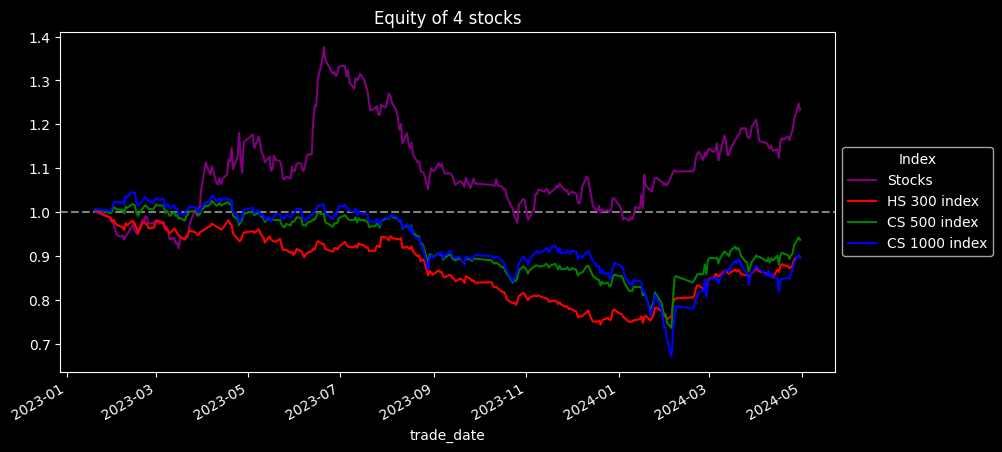

In [87]:
Simple_Backtest(Ensemble_max_factor_df, 4, True)

In [88]:
def Ensure_Future_position_small(factor_df, stock_num, Ascending):
    last_day = factor_df.iloc[-1, :]

    # Calculte the ranks of factors daily.
    factor_ranks = last_day.rank(ascending=Ascending)

    # Create a boolean mask to identify columns where values are between 0 and stock_num - 1
    mask = (factor_ranks > 0) & (factor_ranks <= stock_num)
    print(factor_ranks[mask].sort_values())
    selected_stocks = list(factor_ranks[mask].sort_values().index)
    return selected_stocks

Selected_Stocks = Ensure_Future_position_small(Ensemble_weight_factor_df, 6, True)
Selected_Stocks

ts_code
000651.SZ    1.0
601111.SH    2.0
000333.SZ    3.0
000977.SZ    4.0
300015.SZ    5.0
601998.SH    6.0
Name: 2024-04-30 00:00:00, dtype: float64


['000651.SZ', '601111.SH', '000333.SZ', '000977.SZ', '300015.SZ', '601998.SH']

In [89]:
Trade_Stock_Close_Dict = dict(price.pivot(index="trade_date", 
                                          columns="ts_code", 
                                          values="CLOSE")[Selected_Stocks].iloc[-1, :])
Trade_Stock_Close_Dict

{'000651.SZ': 42.12,
 '601111.SH': 7.38,
 '000333.SZ': 69.78,
 '000977.SZ': 40.91,
 '300015.SZ': 12.9,
 '601998.SH': 6.88}

In [90]:
# Plan A: Buy at open and sell at close
# Plan B:
def Real_trading(Stock_Price_dict, Money, slippage):
    """
    Stamp_duty = 0.0005 (Sell)
    Transfer_fee = 0.00001 (Buy + Sell)
    Commission = 0.00025 (Buy + Sell)(Commission > 5)
    """
    Stock_codes = list(Stock_Price_dict.keys())
    Average_Capital = Money / len(Stock_codes)
    print("Initial Average Capital:", Average_Capital)
    reduce_hand = 0
    position_dict = dict()
    while(1):
        All = 0
        for stock in Stock_codes:
            price = Stock_Price_dict[stock] + slippage
            hands = Average_Capital // (price * 100) - reduce_hand
            Initial = hands * price * 100
            Transfer_fee = Initial * 0.00001
            Commission = Initial * 0.00025 if Initial * 0.00025 >= 5 else 5
            total = Initial + Transfer_fee + Commission
            position_dict[stock] = f"price: {price}, total: {total}, hands: {hands}, fee: {Transfer_fee+Commission}"
            All += Initial + Transfer_fee + Commission
        if All > Money:
            reduce_hand += 1
        else:
            print(f"All init money: {Money}")
            print(f"All position money: {All}")
            break
    return position_dict

In [91]:
Real_trading(Trade_Stock_Close_Dict, 45018303.82, 0)

Initial Average Capital: 7503050.636666667
All init money: 45018303.82
All position money: 45007305.85782


{'000651.SZ': 'price: 42.12, total: 7499309.313599999, hands: 1780.0, fee: 1949.3136',
 '601111.SH': 'price: 7.38, total: 7503720.4602, hands: 10165.0, fee: 1950.4602000000002',
 '000333.SZ': 'price: 69.78, total: 7496320.53672, hands: 1074.0, fee: 1948.53672',
 '000977.SZ': 'price: 40.91, total: 7500752.6887799995, hands: 1833.0, fee: 1949.68878',
 '300015.SZ': 'price: 12.9, total: 7503300.351000001, hands: 5815.0, fee: 1950.351',
 '601998.SH': 'price: 6.88, total: 7503902.5075199995, hands: 10904.0, fee: 1950.50752'}

In [92]:
all_stocks[all_stocks['ts_code'].isin(Selected_Stocks)].set_index('ts_code').reindex(Selected_Stocks).reset_index()

,ts_code,symbol,name,area,industry,fullname,enname,cnspell,market,exchange,curr_type,list_status,list_date,delist_date,is_hs,act_name,act_ent_type
0,000651.SZ,000651,格力电器,广东,家用电器,珠海格力电器股份有限公司,"Gree Electric Appliances,Inc.of Zhuhai",gldq,主板,SZSE,CNY,L,19961118,None,S,珠海市人民政府国有资产监督管理委员会,地方国企
1,601111.SH,601111,中国国航,北京,空运,中国国际航空股份有限公司,Air China Limited,zggh,主板,SSE,CNY,L,20060818,None,H,None,None
2,000333.SZ,000333,美的集团,广东,家用电器,美的集团股份有限公司,"Midea Group Co., Ltd",mdjt,主板,SZSE,CNY,L,20130918,None,S,None,None
3,000977.SZ,000977,浪潮信息,山东,IT设备,浪潮电子信息产业股份有限公司,"Ieit Systems Co., Ltd.",lcxx,主板,SZSE,CNY,L,20000608,None,S,None,None
4,300015.SZ,300015,爱尔眼科,湖南,医疗保健,爱尔眼科医院集团股份有限公司,"Aier Eye Hospital Group Co.,Ltd",aeyk,创业板,SZSE,CNY,L,20091030,None,S,None,None
5,601998.SH,601998,中信银行,北京,银行,中信银行股份有限公司,China Citic Bank Corporation Limited,zxyh,主板,SSE,CNY,L,20070427,None,H,None,None


In [93]:
def execute_trade(stock_data, initial_capital, tickers):
    portfolio = {ticker: {'Position': 0, 'Value': 0, 'Shares': 0} for ticker in tickers}
    
    for ticker in tickers:
        for i in range(len(stock_data)):
            price = stock_data.loc[i, 'Close']
            signal = stock_data.loc[i, 'Signal']
            
            if signal == 1 and portfolio[ticker]['Position'] == 0:
                available_capital = initial_capital - sum([v['Value'] for v in portfolio.values()])
                shares_to_buy = available_capital // price
                portfolio[ticker]['Position'] = 1
                portfolio[ticker]['Value'] = shares_to_buy * price
                portfolio[ticker]['Shares'] = shares_to_buy
                initial_capital -= portfolio[ticker]['Value']
            
            elif signal == 0 and portfolio[ticker]['Position'] == 1:
                initial_capital += portfolio[ticker]['Value']
                portfolio[ticker]['Position'] = 0
                portfolio[ticker]['Value'] = 0
                portfolio[ticker]['Shares'] = 0
                
    return portfolio

### Indexes

1. RankIC mean(IC mean)
2. ICIR
3. IC winning rate
4. IC t-value
5. Long ROI
6. Long sharp
7. Long retracement
8. Long average weekly turnover rate

In [94]:
def Backtest_Indexes(factor_df, Profit_Long):
    # ICIR
    IC_series = factor_df.corrwith(price_return_backtest, axis=1, method="spearman")
    IC_mean = IC_series.mean()
    print(f"IC mean: {IC_mean}")
    ICIR = IC_series.mean() / IC_series.std()
    print(f"ICIR: {ICIR}")
    IC_series.hist(bins=30)

    # RankIC
    # Create a figure and axis
    _, ax = plt.subplots(figsize=(8, 4))
    # Plot histogram of values on the left side
    ax.bar(IC_series.index, IC_series.values)
    ax.set_title('Histogram of Series Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('RankIC')
    # Create a twin Axes sharing the xaxis
    ax2 = ax.twinx()
    # Plot cumulative line on the right side
    ax2.plot(IC_series.index, IC_series.cumsum(), color='orange')
    ax2.set_ylabel('Cumulative Sum')
    
    # IC winning rate
    IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
    print(f"IC winning rate: {IC_winning_rate}")

    t_value = ICIR / sqrt(len(IC_series))
    print(f"IC t-value: {t_value}")

    # Long (Except Short), so `profit_long * 2`
    # profit_long is long equity series.
    Long_equity = Profit_Long * 2
    Long_ROI = (Long_equity[-1]) - 1
    print(f"Long ROI: {Long_ROI}")

    # Max Drawdown
    # Calculate the previous peaks
    previous_peaks = Long_equity.cummax()
    # Calculate the drawdowns
    drawdowns = (Long_equity - previous_peaks) / previous_peaks

    # Find the maximum drawdown and the dates associated with it
    # Convert the index labels to a numeric format
    drawdowns.index = pd.to_numeric(drawdowns.index)
    max_drawdown = drawdowns.min()
    print(f"Max drawdown: {max_drawdown}")
    max_drawdown_start = drawdowns.idxmin()

    # Convert the start and end dates back to the original format if needed
    max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
    print(f"Max drawdown begin date: {max_drawdown_start}")

    plt.show()

IC mean: -0.0869368150469701
ICIR: -0.537465512875151
IC winning rate: 0.26058631921824105
IC t-value: -0.030674777038346625
Long ROI: 0.04169323157529292
Max drawdown: -0.2586538571887631
Max drawdown begin date: 2024-01-17


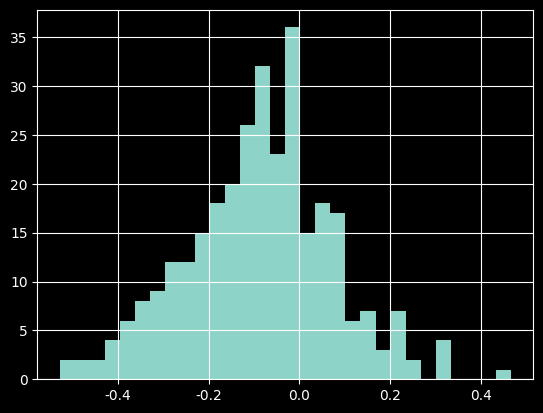

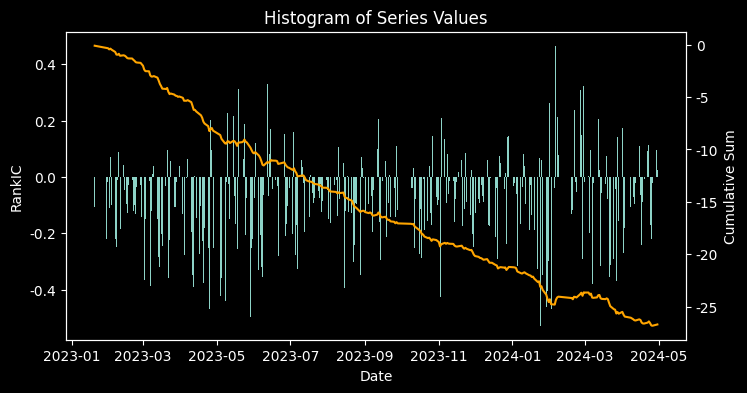

In [95]:
Backtest_Indexes(Ensemble_max_factor_df, profit_long_Ensemble_max)

IC mean: -0.0760314179508512
ICIR: -0.5298739160877413
IC winning rate: 0.2768729641693811
IC t-value: -0.03024150172441422
Long ROI: 0.020056637419201495
Max drawdown: -0.25278166736859853
Max drawdown begin date: 2024-01-10


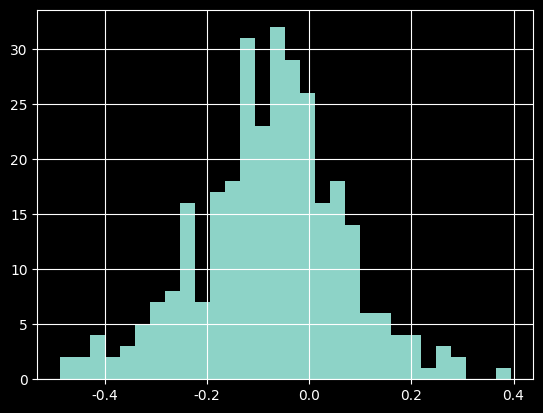

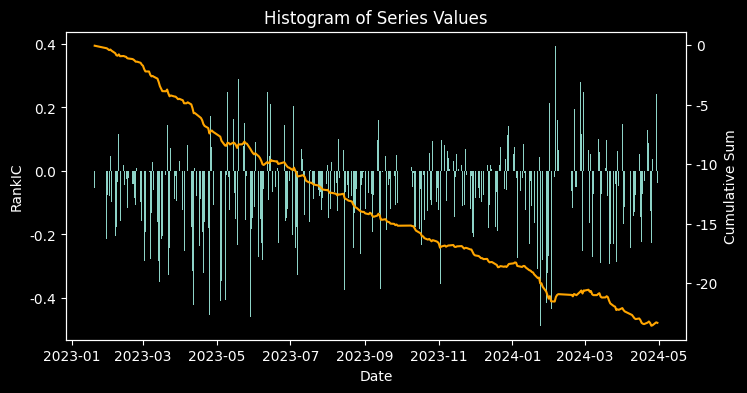

In [96]:
Backtest_Indexes(Ensemble_weight_factor_df, profit_long_Ensemble_weight)

IC mean: -0.08876428047273802
ICIR: -0.5399366738218428
IC winning rate: 0.26058631921824105
IC t-value: -0.030815813643021297
Long ROI: 0.031125757178460223
Max drawdown: -0.2586538571887631
Max drawdown begin date: 2024-01-17


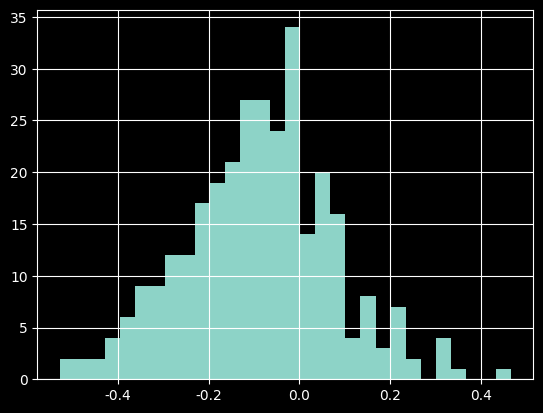

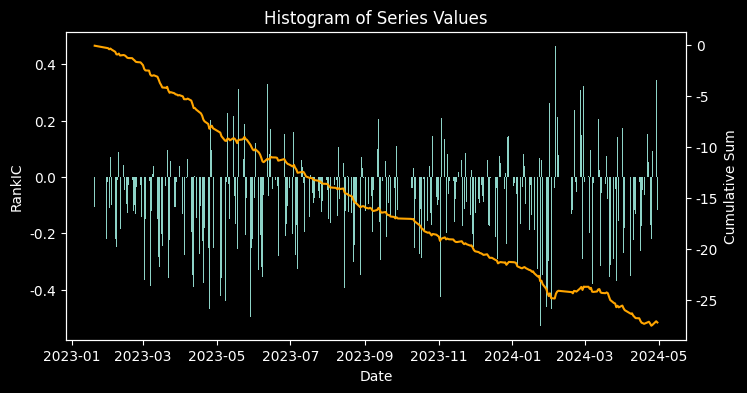

In [97]:
Backtest_Indexes(MLP_factor_backtest, profit_long_MLP)

IC mean: -0.049233870078975166
ICIR: -0.4484647973907348
IC winning rate: 0.30618892508143325
IC t-value: -0.025595237908229516
Long ROI: 0.03203602595545929
Max drawdown: -0.24526452623929426
Max drawdown begin date: 2024-01-17


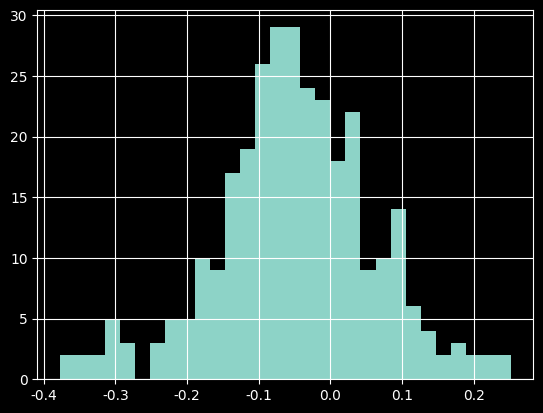

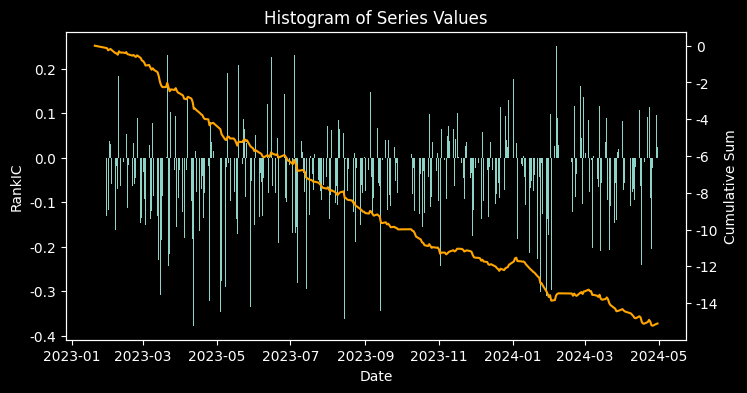

In [98]:
Backtest_Indexes(GBDT_factor_backtest, profit_long_GBDT)

IC mean: -0.003885705753919587
ICIR: -0.05850896322856006
IC winning rate: 0.46905537459283386
IC t-value: -0.00333928290985585
Long ROI: 0.06419371765962434
Max drawdown: -0.2549848810386205
Max drawdown begin date: 2024-01-22


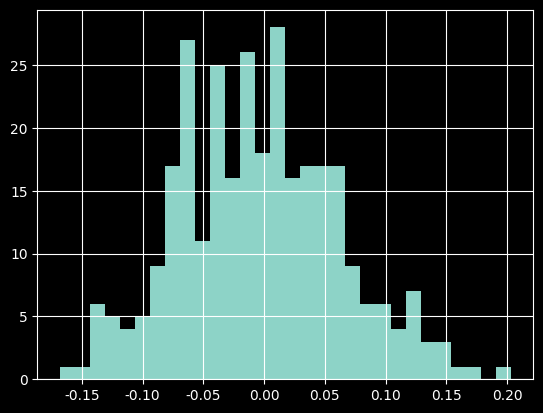

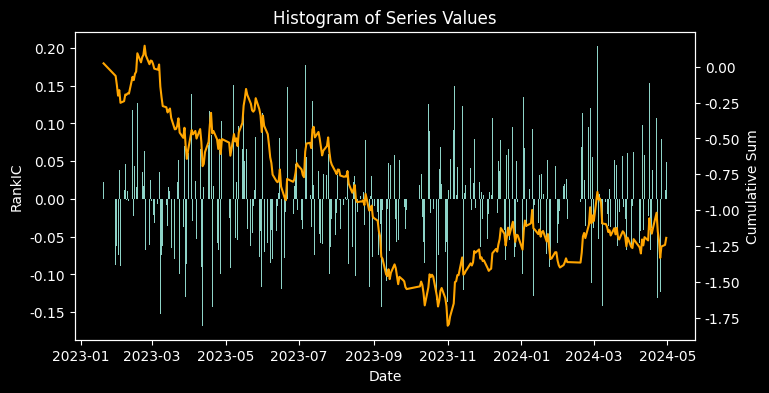

In [99]:
Backtest_Indexes(AGRU_factor_backtest, profit_long_AGRU)

### Correlation

##### 1. Factor Correlation

In [100]:
def Factor_Correlation(*Factor_df, type_list):
    # Factor cross-sectional correlation
    for i in range(len(Factor_df) - 1):
        temp_df = Factor_df[i]
        for j in range(i + 1, len(Factor_df)):
            temp_df.corrwith(Factor_df[j], axis=1).plot(label=f'{type_list[i]} & {type_list[j]}',
                                                        legend=True)
    plt.title(f"Correlation of Daily Factor Values")
    plt.legend(title="Factors", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

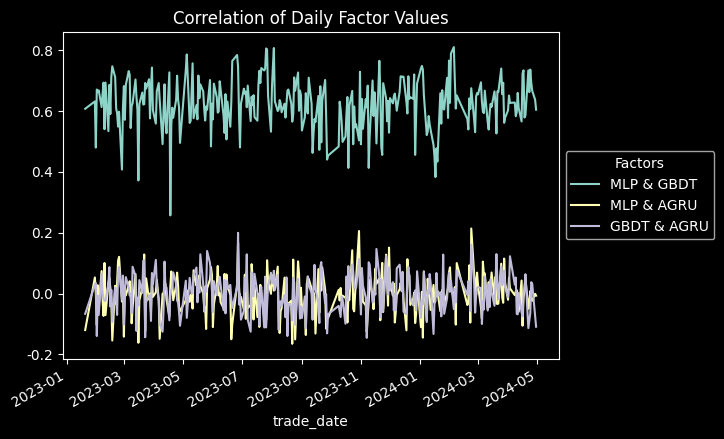

In [101]:
Factor_Correlation(MLP_factor_backtest, 
                   GBDT_factor_backtest, 
                   AGRU_factor_backtest,
                   type_list=["MLP", "GBDT", "AGRU"])

In Python, `*args` and `**kwargs` are used to pass a variable number of arguments to a function.

- `*args`: The `*args` parameter in a function definition allows you to pass a variable number of positional arguments. When you use `*args` in a function definition, it collects all the positional arguments passed to the function into a tuple. You can then iterate over this tuple to access each argument.

Example:
```python
def my_function(*args):
    for arg in args:
        print(arg)

my_function('apple', 'banana', 'cherry')
```

Output:
```
apple
banana
cherry
```

- `**kwargs`: The `**kwargs` parameter in a function definition allows you to pass a variable number of keyword arguments. When you use `**kwargs` in a function definition, it collects all the keyword arguments passed to the function into a dictionary where the keys are the argument names and the values are the argument values.

Example:
```python
def my_function(**kwargs):
    for key, value in kwargs.items():
        print(f"{key}: {value}")

my_function(fruit='apple', color='red', price=1.00)
```

Output:
```
fruit: apple
color: red
price: 1.00
```

By using `*args` and `**kwargs`, you can create functions that are flexible and can accept a varying number of arguments, both positional and keyword arguments.

##### 2. Average IC Correlation

In [102]:
def Factor_Correlation(*Factor_df, type_list):
    # Factor cross-sectional correlation
    for i in range(len(Factor_df) - 1):
        temp_df = Factor_df[i]
        for j in range(i + 1, len(Factor_df)):
            temp_df.corrwith(Factor_df[j], axis=1).plot(label=f'{type_list[i]} & {type_list[j]}',
                                                        legend=True)
    plt.title(f"Correlation of Daily Factor Values")
    plt.legend(title="Factors", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

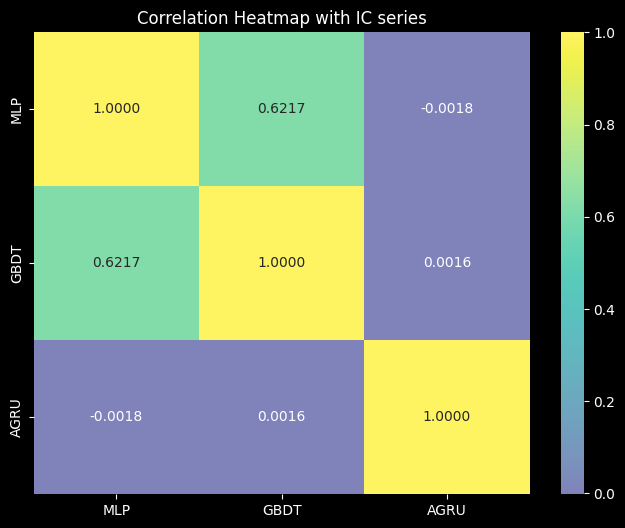

In [103]:
def Average_IC_Correlation(*Factor_df, type_list):
    # Average Factor cross-sectional correlatcolumnsion
    matrix = pd.DataFrame(index=type_list, columns=type_list)
    np.fill_diagonal(matrix.values, 1) # Assign it with unit matrix
    for i in range(len(Factor_df) - 1):
        temp_df = Factor_df[i]
        for j in range(i + 1, len(Factor_df)):
            corr = temp_df.corrwith(Factor_df[j], axis=1).mean()
            # This is a symmetric matrix.
            matrix.iat[i, j] = corr
            matrix.iat[j, i] = corr
    return matrix
Average_IC_matrix = Average_IC_Correlation(
    MLP_factor_backtest,
    GBDT_factor_backtest,
    AGRU_factor_backtest,
    type_list=["MLP", "GBDT", "AGRU"],
)
# Convert data type of Average_IC_matrix to float for heatmap
Average_IC_matrix = Average_IC_matrix.astype(float)

# Create a heatmap
plt.figure(figsize=(8, 6))

# Create a custom color map with reduced brightness based on 'viridis'
viridis_cmap = plt.colormaps.get_cmap('viridis')
new_colors = viridis_cmap(np.linspace(0.2, 1, 256)) ** 0.5  # Adjust the brightness level here
custom_cmap = sns.color_palette(new_colors)

sns.heatmap(Average_IC_matrix, annot=True, cmap=custom_cmap, fmt=".4f")
plt.title('Correlation Heatmap with IC series')
plt.show()

##### 3. IC series Correlation

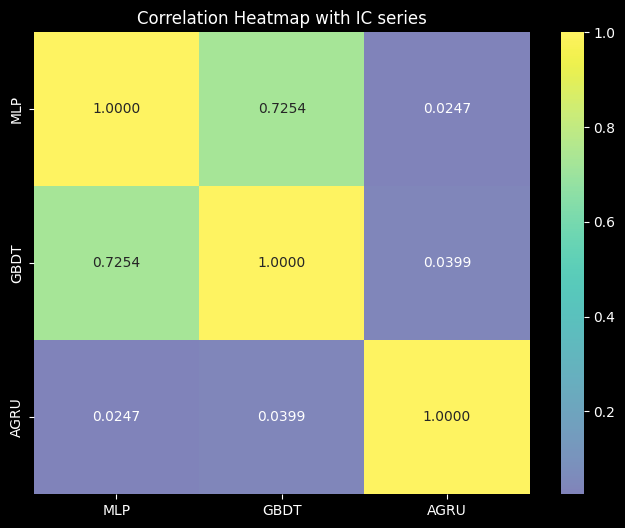

In [104]:
def IC_Correlation(*factor_df, price_return, type_list):
    # Correlation of factor IC series
    Correlation_df = None
    for factor in factor_df:
        Corr = factor.corrwith(price_return, axis=1)
        Correlation_df = pd.concat([Correlation_df, Corr], axis=1)
    # Change the columns to type_list
    Correlation_df.columns = type_list
    return Correlation_df

IC_Correlation_df = IC_Correlation(
    MLP_factor_backtest,
    GBDT_factor_backtest,
    AGRU_factor_backtest,
    price_return=price_return_backtest,
    type_list=["MLP", "GBDT", "AGRU"],
)
IC_Correlation_matrix = IC_Correlation_df.corr()
# Create a heatmap
plt.figure(figsize=(8, 6))

# Create a custom color map with reduced brightness based on 'viridis'
viridis_cmap = plt.colormaps.get_cmap('viridis')
new_colors = viridis_cmap(np.linspace(0.2, 1, 256)) ** 0.5  # Adjust the brightness level here
custom_cmap = sns.color_palette(new_colors)

sns.heatmap(IC_Correlation_matrix, annot=True, cmap=custom_cmap, fmt=".4f")
plt.title('Correlation Heatmap with IC series')
plt.show()